# Data Cleaning and EDA

This notebook serves the purpose of ingesting, preparing and analyzing the main dataset used for the thesis, the HMDA mortgage dataset. The dataset is a collection of mortgage applications in the United States, and it contains information about the applicants, the loans, and the outcomes of the applications. The dataset is publicly available and can be found [here](https://ffiec.cfpb.gov/data-browser/data/2022?category=states). 

## Data Ingestion

The data in question (Please refer to the corresponding chapter within the thesis for a detailed description of the applied filters and their rationale) is available for download in a .csv format and can therefore be ingested as a dataframe using the inbuilt read_csv function of the pandas library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu


sns.set_theme(style="darkgrid", context= "paper")

In [2]:
HMDA_raw = pd.read_csv("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/raw/HMDA/CA_2022_SingleFamily_Built.csv")

C:\Users\Hauke\AppData\Local\Temp\ipykernel_21364\1082769657.py:1: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,44) have mixed types. Specify dtype option on import or set low_memory=False.
  HMDA_raw = pd.read_csv("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/raw/HMDA/CA_2022_SingleFamily_Built.csv")


## Exploratory Data Analysis (EDA) - Raw Data

In order to prepare the data for processing, its raw form is analyzed in order to identify potential issues and to gain a better understanding of the data. In order to do so, basic EDA steps will be conducted at this stage, before more refined analyses will be conducted after the data has been cleaned and prepared for processing.

In [3]:
HMDA_raw.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,5493000YNV8IX4VD3X12,40140,CA,6065.0,6.065044e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,3895,72.04,87400,51,637,1091,46
1,2022,5493000YNV8IX4VD3X12,40140,CA,6065.0,6.065041e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,4599,75.80,87400,92,1231,1560,36
2,2022,5493000YNV8IX4VD3X12,40140,CA,6065.0,6.065042e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,3835,83.94,87400,78,154,416,10
3,2022,5493000YNV8IX4VD3X12,33700,CA,6099.0,6.099000e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,8312,42.61,79300,129,1584,2342,20
4,2022,5493000YNV8IX4VD3X12,37100,CA,6111.0,6.111001e+09,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,2107,26.39,115400,128,512,942,50


In [4]:
HMDA_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503537 entries, 0 to 1503536
Data columns (total 99 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   activity_year                             1503537 non-null  int64  
 1   lei                                       1503537 non-null  object 
 2   derived_msa-md                            1503537 non-null  int64  
 3   state_code                                1503537 non-null  object 
 4   county_code                               1493002 non-null  float64
 5   census_tract                              1492061 non-null  float64
 6   conforming_loan_limit                     1503537 non-null  object 
 7   derived_loan_product_type                 1503537 non-null  object 
 8   derived_dwelling_category                 1503537 non-null  object 
 9   derived_ethnicity                         1503537 non-null  object 
 10  derive

In [5]:
HMDA_raw.describe()

,activity_year,derived_msa-md,county_code,census_tract,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
count,1503537.0,1.503537e+06,1.493002e+06,1.492061e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,...,40759.000000,7054.000000,793.000000,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06
mean,2022.0,3.620769e+04,6.057078e+03,6.057253e+09,2.501587e+00,4.981873e+00,1.981012e+00,1.201846e+00,1.418716e+01,1.207833e+00,...,5.002233,6.271761,7.315259,5.020362e+03,5.905775e+01,1.031129e+05,1.166305e+02,1.053468e+03,1.480468e+03,3.993513e+01
std,0.0,1.390486e+04,2.661617e+01,2.714773e+07,1.775274e+00,1.646557e+01,1.364821e-01,5.181575e-01,1.481168e+01,4.057565e-01,...,2.670639,2.375737,2.081419,1.939129e+03,2.383132e+01,2.697459e+04,4.712574e+01,5.127602e+02,6.070215e+02,1.832085e+01
min,2022.0,0.000000e+00,6.001000e+03,6.001400e+09,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022.0,3.108400e+04,6.037000e+03,6.037408e+09,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.000000,4.000000,6.000000,3.740000e+03,3.954000e+01,8.740000e+04,8.400000e+01,6.880000e+02,1.071000e+03,2.700000e+01
50%,2022.0,4.014000e+04,6.065000e+03,6.065042e+09,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,...,4.000000,6.000000,9.000000,4.864000e+03,5.903000e+01,9.110000e+04,1.110000e+02,1.004000e+03,1.429000e+03,4.200000e+01
75%,2022.0,4.174000e+04,6.073000e+03,6.073017e+09,4.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,3.200000e+01,1.000000e+00,...,7.000000,9.000000,9.000000,6.079000e+03,8.020000e+01,1.154000e+05,1.440000e+02,1.362000e+03,1.854000e+03,5.400000e+01
max,2022.0,9.999900e+04,6.115000e+03,1.306703e+10,8.000000e+00,7.200000e+01,2.000000e+00,4.000000e+00,3.200000e+01,2.000000e+00,...,9.000000,9.000000,9.000000,3.789200e+04,1.000000e+02,1.683000e+05,3.270000e+02,3.467000e+03,7.708000e+03,8.000000e+01


In [6]:
HMDA_raw["loan_amount"].sum()

755869735000.0

## Data Preparation

Due to the sheer size of the dataset, several preprocessing steps need to be taken before the actual EDA can be conducted. These steps include the removal of irrelevant columns, the handling of missing values, and the encoding of categorical variables.

### Reducing amount of features

The raw dataset contains 99 features (CHECK!!!). Many of these are highly relevant to this analysis, but in order to find a compromise between model performance and computational efficiency, only a subset of features will be used for further analysis. In the following step, all features which can be reasoned to not benefit the analysis are removed from the dataset. Details on the reasoning behind the removal of each feature can be found below.

In [7]:
HMDA_clean = HMDA_raw.copy()

In the first step, several "administrative" features which are not relevant for the analysis are removed. These are:
- **activity_year**: Does not provide value as the year is already pre-filtered
- **lei**: Does not matter as all financial institutions are used
- **derived_msa-md**: Does not matter as county code is the geographical variable used in the analysis
- **state_code**: Does not matter as the state is already pre-filtered
- **census_tract**: Not relevant for the analysis
- **derived_dwelling_category** and **construction_method**: Do not matter as the building category is already pre-filtered

In [8]:
HMDA_clean = HMDA_clean.drop(columns=["activity_year", "lei", "derived_msa-md", "state_code", "census_tract", "derived_dwelling_category", "construction_method"])

While information on both the applicant and the co-applicant is available, the focus of the following analyses should be the main applicant. Therefore, all features related to the co-applicant are removed.

In [9]:
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='co-applicant')))]

Reasons for Denial are dropped, as only the classification of the loan is of interest

In [10]:
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='denial_reason')))]

The dataset contains geographical information based on census tracts. As, however, the analysis of geographical features will be based on county level, the census tract is dropped.

In [11]:
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='tract_')))]
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='ffiec_msa_md_median_family_income')))]

The dataset contains both actual information on specific protected attributes (e.g. "applicant_ethnicity-1" to "applicant_ethniciy-5") and derived information that aggregate the former into one overarching category (e.g. "derived_ethnicity"). As this analysis focuses on fairness concerns, where such protected attributes play an important role, the derived information is dropped in favor of the actual information in order to achieve a higher granularity of this important type of data. However, as only few applicants have made use of all the fields (for example, only 0.07% of applicants have reported more than two ethnicities), the amount of features is reduced by only including the top two selections for each protected attribute. This is done in order to avoid a high amount of missing values in the dataset as well as to strike a balance between the amount of features (and therefore model performance) and the granularity of the data.

In [12]:
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='derived')))]
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='-3')))]
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='-4')))]
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='-5')))]

### EDA after feature reduction

This is the first analysis of the remaining features. All features that could be dropped for logical reasons have been removed, and the remaining features are analyzed in order to identify potential issues and to gain a better understanding of the data. This is done in order to identify potential issues that need to be addressed in the next step, the data cleaning.

In [13]:
HMDA_clean.shape

(1503537, 51)

The dataset still has 52 (!!!!!!) features remaining. The amount of items has not yet been reduced. The following EDA steps will mainly focus on data completeness and data types, as well as the distribution of the remaining features.

In [14]:
HMDA_clean.head()

,county_code,conforming_loan_limit,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,...,applicant_race-2,applicant_race_observed,applicant_sex,applicant_sex_observed,applicant_age,applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus-1,aus-2
0,6065.0,C,6,0,2,1,5,1,2,2,...,NaN,3,4,3,8888,NaN,3,3,6,NaN
1,6065.0,C,6,0,2,2,5,1,2,2,...,NaN,3,4,3,8888,NaN,3,3,6,NaN
2,6065.0,C,6,0,2,2,1,1,2,2,...,NaN,3,4,3,8888,NaN,3,3,6,NaN
3,6099.0,C,1,1,2,1,1,1,2,2,...,NaN,2,1,2,45-54,No,1,1,1,NaN
4,6111.0,NC,3,0,2,1,31,1,2,2,...,NaN,2,1,2,55-64,No,1,1,6,NaN


In [15]:
HMDA_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503537 entries, 0 to 1503536
Data columns (total 51 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   county_code                               1493002 non-null  float64
 1   conforming_loan_limit                     1503537 non-null  object 
 2   action_taken                              1503537 non-null  int64  
 3   purchaser_type                            1503537 non-null  int64  
 4   preapproval                               1503537 non-null  int64  
 5   loan_type                                 1503537 non-null  int64  
 6   loan_purpose                              1503537 non-null  int64  
 7   lien_status                               1503537 non-null  int64  
 8   reverse_mortgage                          1503537 non-null  int64  
 9   open-end_line_of_credit                   1503537 non-null  int64  
 10  busine

In [16]:
HMDA_clean.describe()

,county_code,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,...,applicant_ethnicity_observed,applicant_race-1,applicant_race-2,applicant_race_observed,applicant_sex,applicant_sex_observed,submission_of_application,initially_payable_to_institution,aus-1,aus-2
count,1.493002e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,...,1.503537e+06,1.503145e+06,174743.000000,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,127657.000000
mean,6.057078e+03,2.501587e+00,4.981873e+00,1.981012e+00,1.201846e+00,1.418716e+01,1.207833e+00,7.539741e+00,7.367562e+00,7.743682e+00,...,2.111181e+00,5.329366e+00,21.589031,2.109359e+00,1.725825e+00,2.110209e+00,7.090578e+00,6.987861e+00,1.031965e+01,2.084359
std,2.661617e+01,1.775274e+00,1.646557e+01,1.364821e-01,5.181575e-01,1.481168e+01,4.057565e-01,7.831285e+01,7.832594e+01,7.998826e+01,...,3.544959e-01,3.274854e+00,6.579014,3.536678e-01,9.521703e-01,3.547938e-01,7.917898e+01,7.918662e+01,8.464235e+01,1.415688
min,6.001000e+03,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
25%,6.037000e+03,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,5.000000e+00,21.000000,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
50%,6.065000e+03,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,5.000000e+00,22.000000,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,2.000000
75%,6.073000e+03,4.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,3.200000e+01,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,6.000000e+00,24.000000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,6.000000e+00,2.000000
max,6.115000e+03,8.000000e+00,7.200000e+01,2.000000e+00,4.000000e+00,3.200000e+01,2.000000e+00,1.111000e+03,1.111000e+03,1.111000e+03,...,3.000000e+00,4.400000e+01,44.000000,3.000000e+00,6.000000e+00,3.000000e+00,1.111000e+03,1.111000e+03,1.111000e+03,7.000000


Several columns are cast as objects, but should be cast as numerical values. The following steps aim to gain insight into which features are of object type and why.

In [17]:
HMDA_clean.dtypes[HMDA_clean.dtypes == "object"]

object_columns = list(HMDA_clean.select_dtypes(include=['object']).columns)

In [18]:
HMDA_clean[object_columns].head(15)

,conforming_loan_limit,loan_to_value_ratio,interest_rate,rate_spread,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,property_value,multifamily_affordable_units,debt_to_income_ratio,applicant_age,applicant_age_above_62
0,C,NaN,6.99,NaN,NaN,NaN,NaN,NaN,NaN,480,NaN,NaN,275000.0,NaN,NaN,8888,NaN
1,C,NaN,4.375,NaN,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,315000.0,NaN,NaN,8888,NaN
2,C,NaN,3.5,NaN,10574.0,NaN,995.0,NaN,2170.63,360,NaN,NaN,395000.0,NaN,NaN,8888,NaN
3,C,43.182,5.25,0.185,4342.0,NaN,1232.5,237.5,8.0,360,NaN,NaN,445000.0,NaN,20%-<30%,45-54,No
4,NC,53.731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,2605000.0,NaN,<20%,55-64,No
5,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240,NaN,NaN,NaN,NaN,NaN,25-34,No
6,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,NaN,NaN,NaN,45-54,No
7,C,75.0,7.5,0.605,6005.0,NaN,1595.0,600.0,211.5,360,NaN,NaN,645000.0,NaN,46,45-54,No
8,NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,NaN,NaN,NaN,55-64,Yes
9,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,NaN,NaN,NaN,55-64,No


The object type columns seem to partially be wrongly encoded numerical values and in part categorical variables. This will be important in the upcoming data cleaning steps.

The next step is to identify the missing values and to assess whether they are MCAR, MAR, or MNAR, which is important to know in order to decide on how to proceed with the missing values.

In [19]:
HMDA_clean.isnull().sum().sort_values(ascending=False)

multifamily_affordable_units                1496109
total_points_and_fees                       1484569
prepayment_penalty_term                     1381569
aus-2                                       1375880
applicant_ethnicity-2                       1346991
applicant_race-2                            1328794
lender_credits                              1235230
discount_points                             1127409
intro_rate_period                           1116434
total_loan_costs                             808930
origination_charges                          793497
rate_spread                                  772188
interest_rate                                543270
debt_to_income_ratio                         522567
loan_to_value_ratio                          500712
property_value                               332504
income                                       162449
applicant_age_above_62                       139119
loan_term                                     37032
county_code 

There are several columns with missing values, some of them being majorly incomplete. The next step is to assess the missing values in more detail and to decide on how to proceed with them. First, the values within the columns are checked in order to understand what the missing values represent.

In [20]:
for item in HMDA_clean.isnull().sum().sort_values(ascending=False)[:15].index:
    print(item, HMDA_clean[item].unique())

multifamily_affordable_units [nan 'Exempt']
total_points_and_fees [nan 'Exempt' '0.0' ... '15274.76' '10049.0' '14355.94']
prepayment_penalty_term [nan 60.0 36.0 24.0 12.0 'Exempt' 18.0 300.0 '36' '12' '24' '60' '5' 0.0
 48.0 '6' '48' '3' '2' 2]
aus-2 [nan  2.  1.  3.  5.  7.  4.]
applicant_ethnicity-2 [nan 11. 12. 14.  2. 13.  1.]
applicant_race-2 [nan 21.  5. 24. 22. 27. 23. 25.  3. 26. 42.  4.  2. 44. 43. 41.  1.]
lender_credits [nan 2170.63 8.0 ... '3705.45' '4166.5' '1020.06']
discount_points [nan 237.5 600.0 ... '4132.07' '5830.63' '7027.65']
intro_rate_period [nan 120.0 84.0 60.0 36.0 62.0 180.0 63.0 61.0 6.0 360.0 '60' '84' '360'
 '120' 'Exempt' '1' '180' 12.0 1.0 48.0 64.0 4.0 '12' '6' 3.0 '299' '2'
 '61' '66' '30' '36' 2.0 13.0 5.0 '3' '9' '24' '3012022' '111' '114' '62'
 '90' '83' '64' '11' '10' '7' 96.0 '4' '5' '96' '13' '72' 9.0 98.0 14.0
 16.0 15.0 11.0 17.0 22.0 58.0 '35' '25' '63' '85' '48' '8' '18' '91' '21'
 '68' '37' '108' '92' '89' '106' '87' '103' '97' '14' '17' '1

Following up, the missingno package (https://github.com/ResidentMario/missingno?tab=readme-ov-file) is utilized to visualize the missing values in the dataset in order to find patterns upon optical inspection.

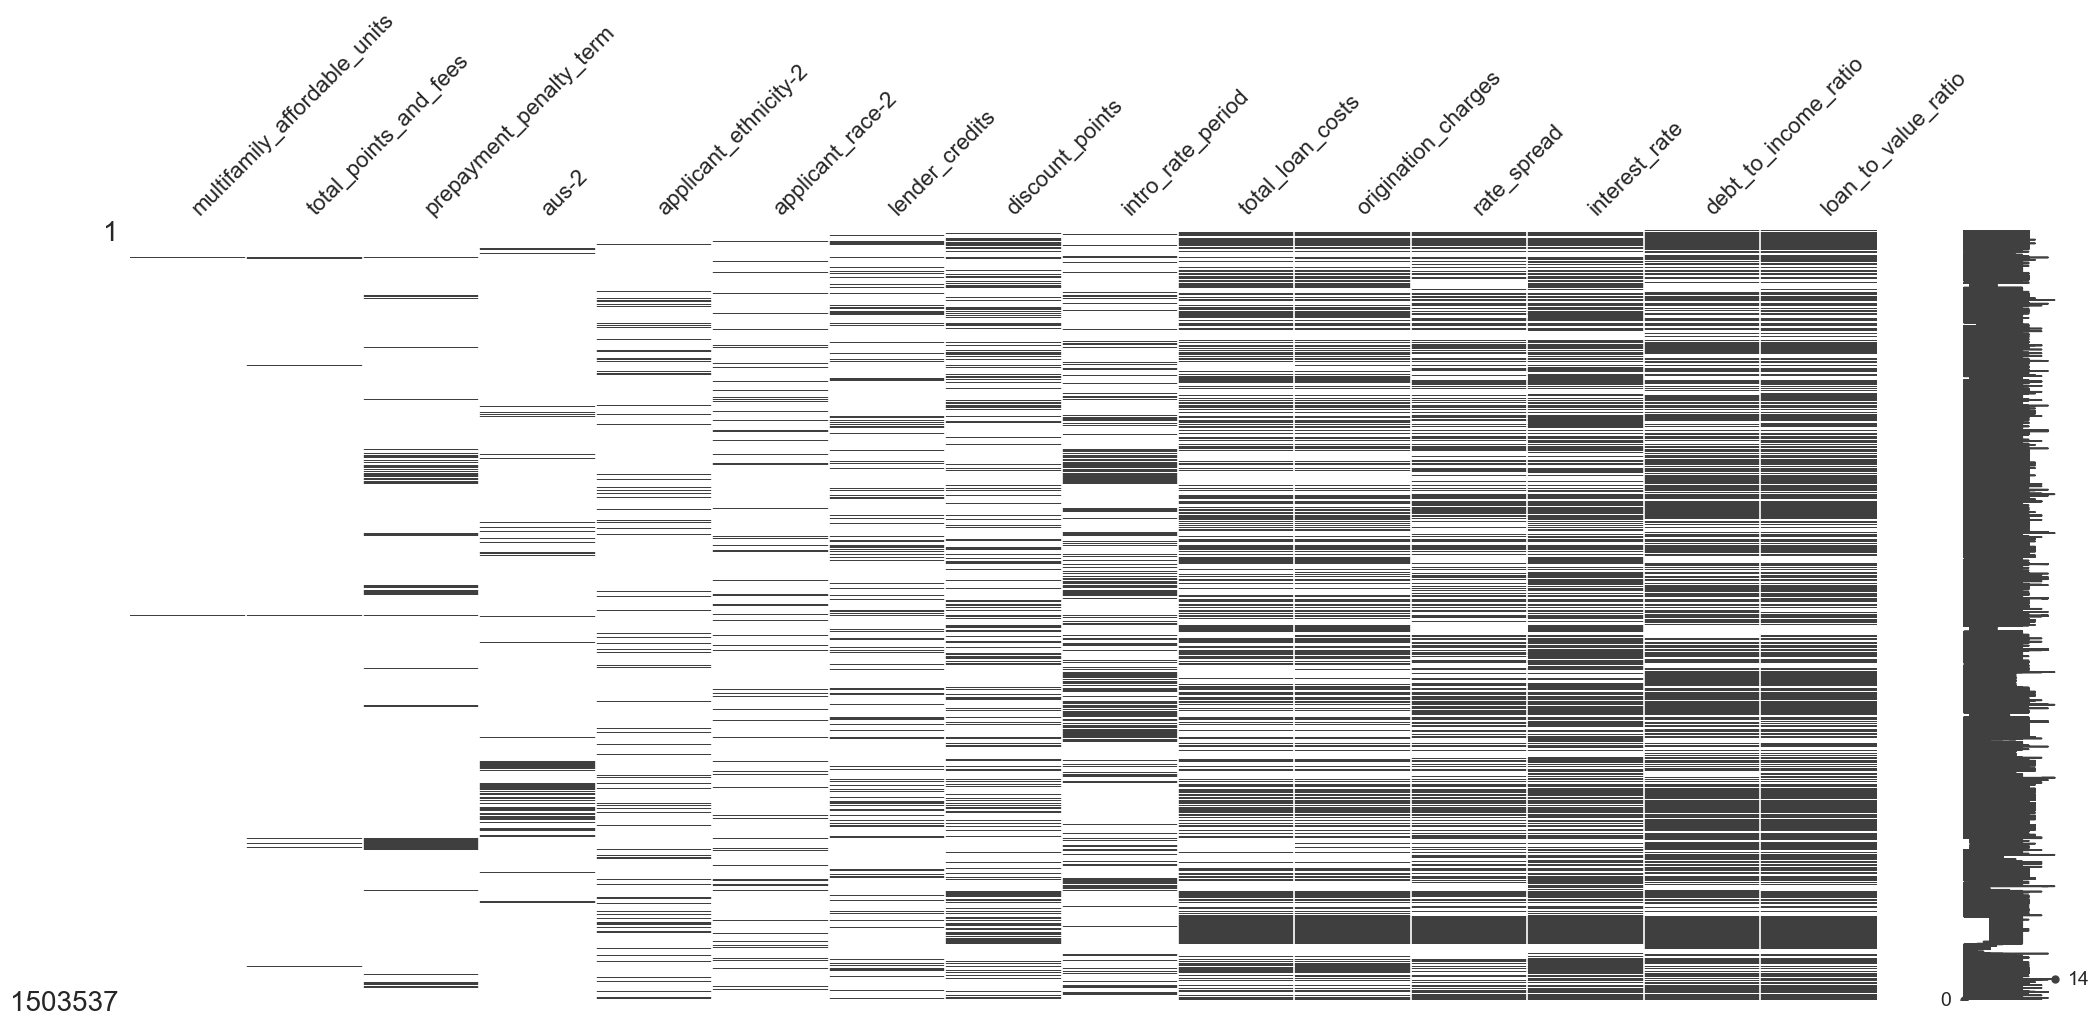

In [21]:
import missingno as msno
msno.matrix(HMDA_clean[HMDA_clean.isnull().sum().sort_values(ascending=False).head(15).index]);

<AxesSubplot: >

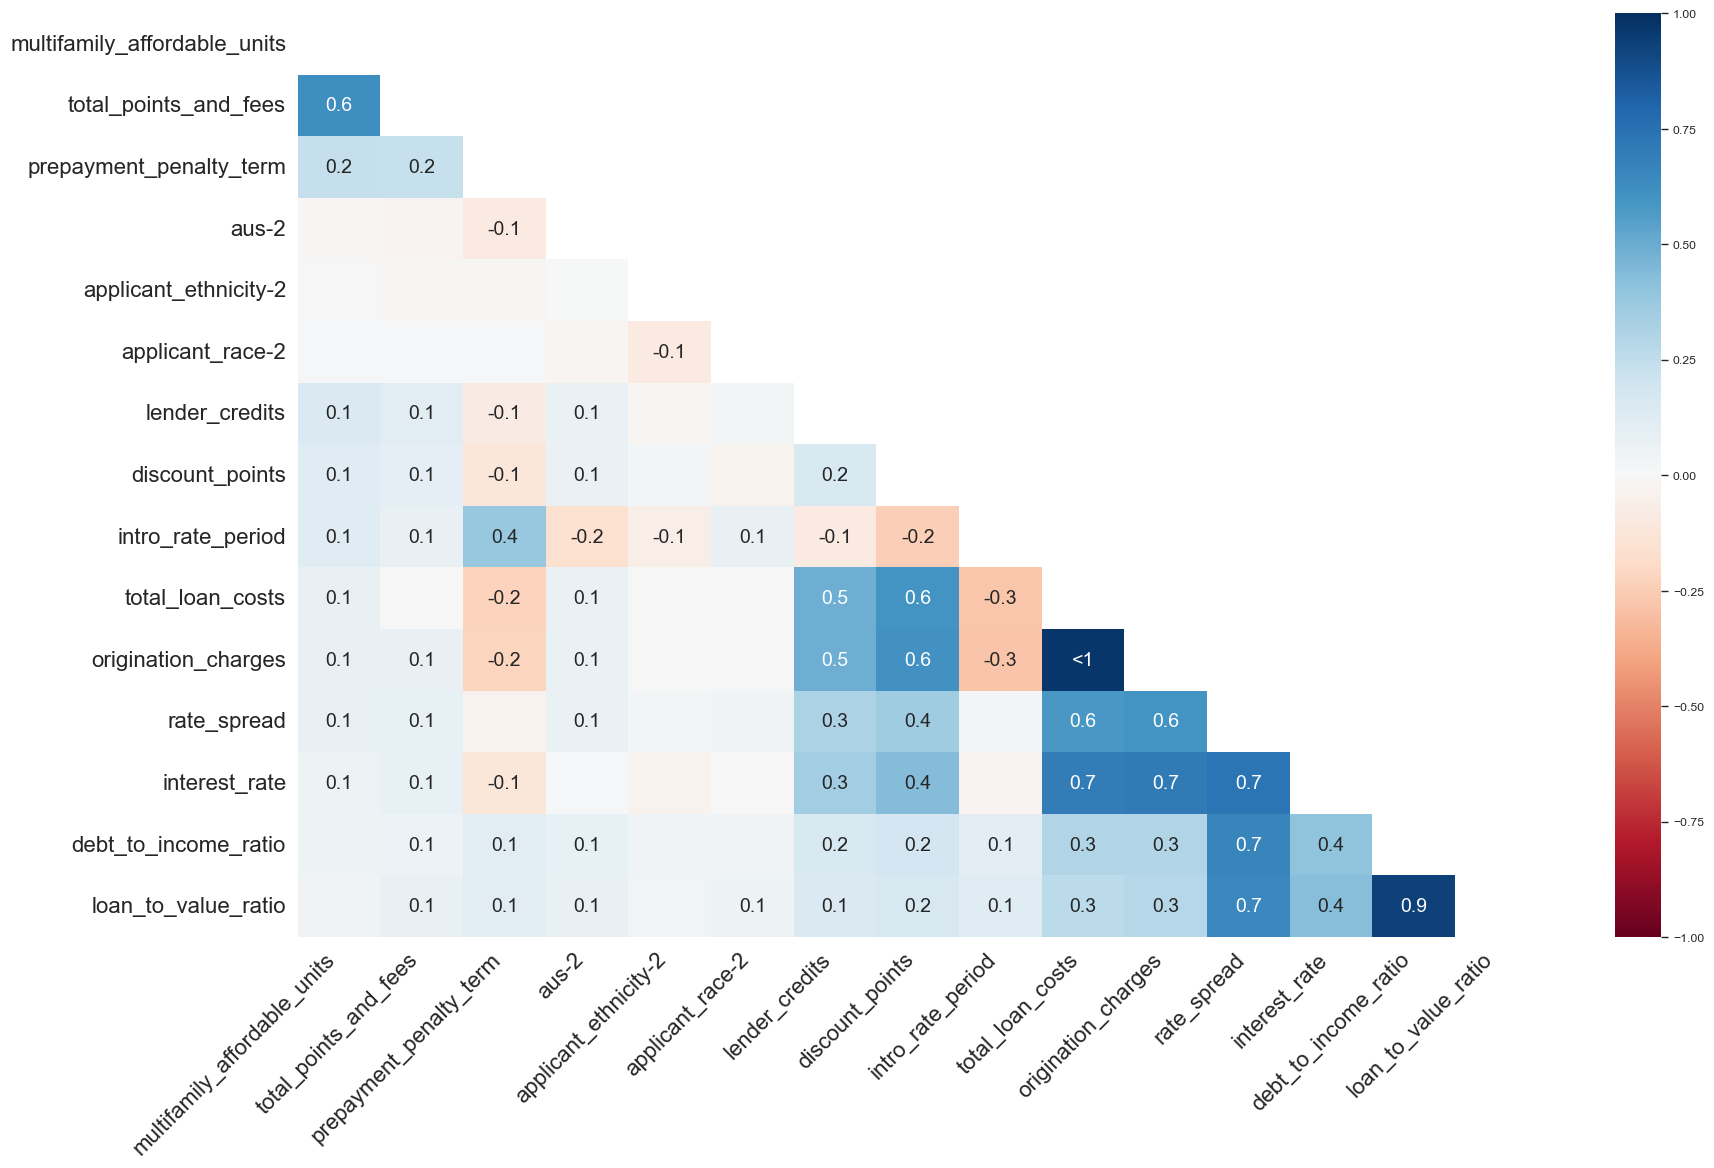

In [22]:
msno.heatmap(HMDA_clean[HMDA_clean.isnull().sum().sort_values(ascending=False).head(15).index])

<AxesSubplot: >

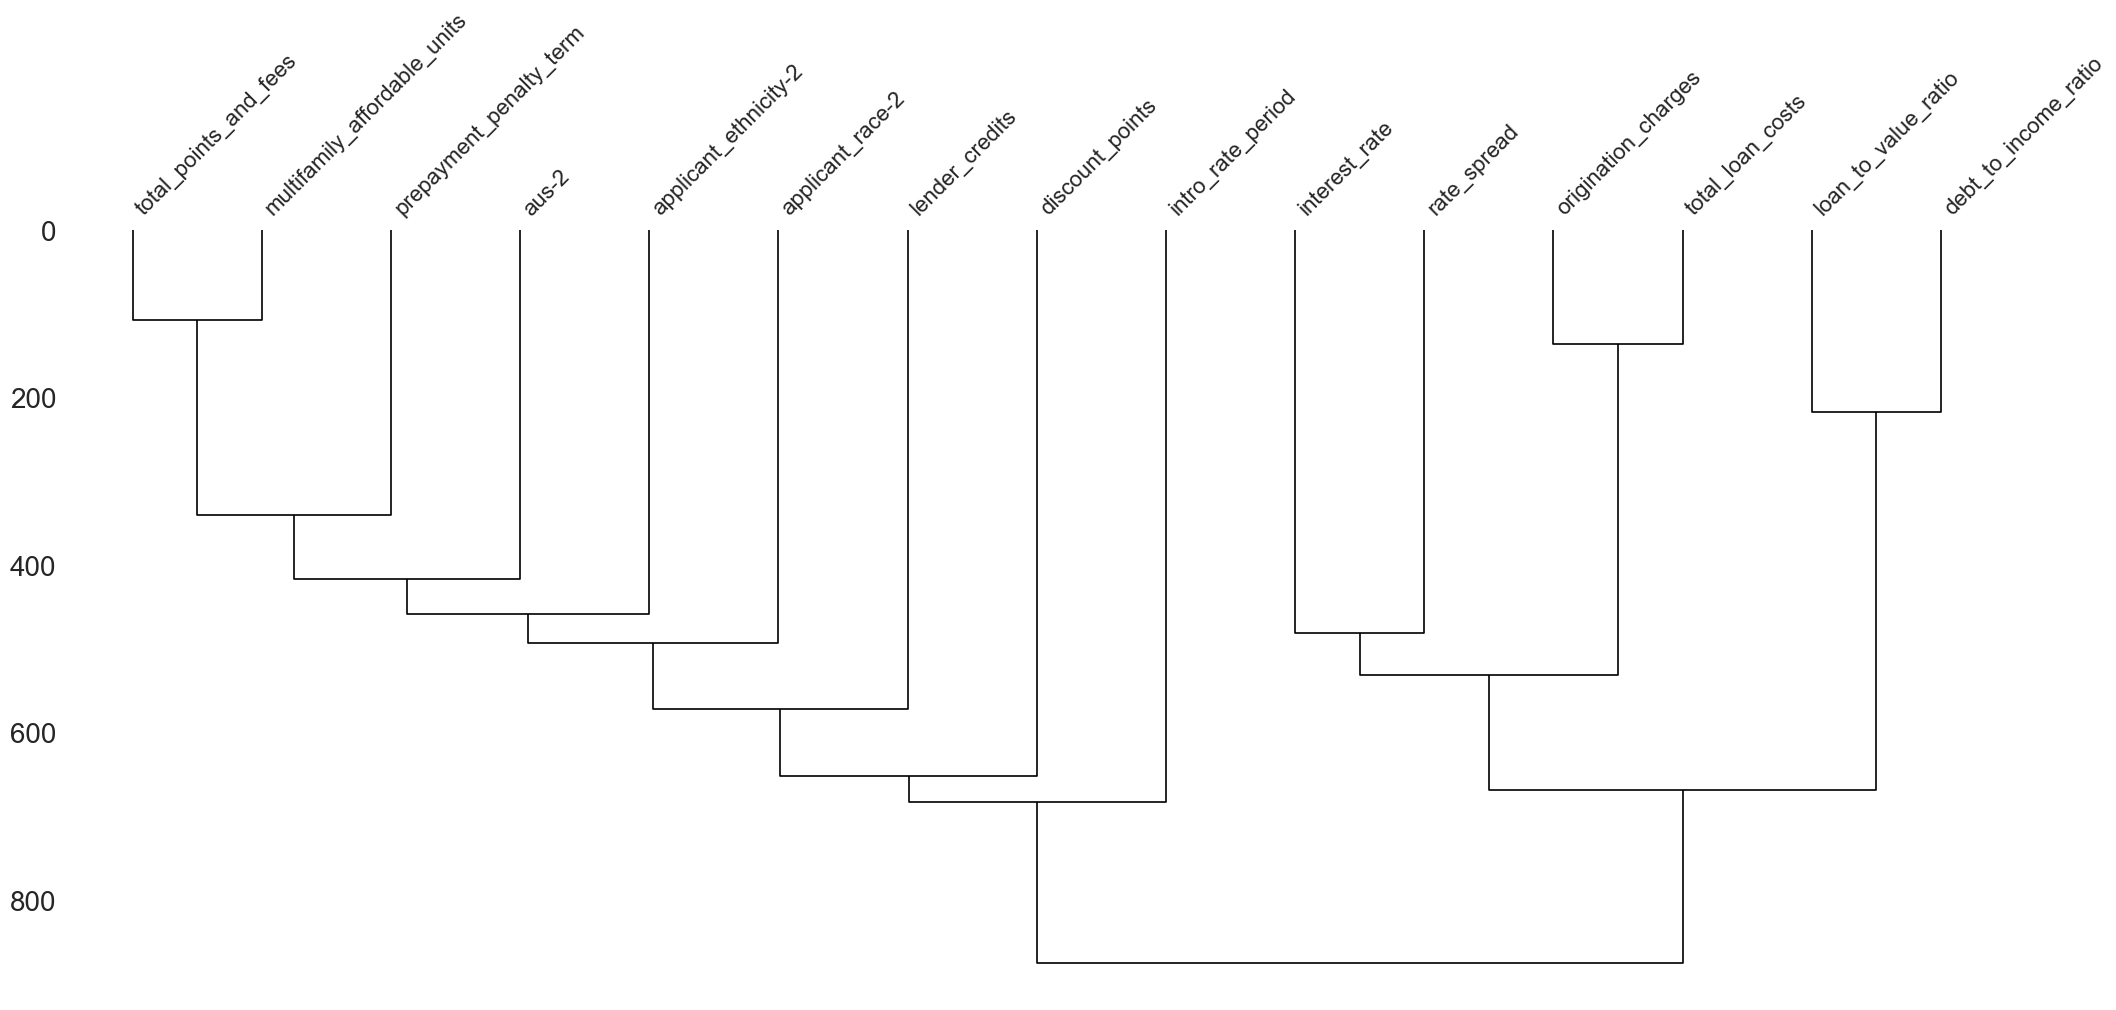

In [23]:
msno.dendrogram(HMDA_clean[HMDA_clean.isnull().sum().sort_values(ascending=False).head(15).index])

XXX Problem: Might change with new data XXX

There are several columns containing a high amount of missing values (see above). The procedure for handling these missing values is as follows:
- **multifamily_affordable_units**: This column seems to be erroneous, as it contains only one unique value ("Exempt"), whereas it is supposed to contain percentages according to the documentation. It is therefore dropped. 
- **total_points_and_fees**, **prepayment_penalty_term**, **lender_credits**,  **discount_points**, and **intro_rate_period**: These might have been interesting to include in the analysis. However, the sheer amount of missingness (which seems to be MCAR from visual inspection) makes them unsuitable for the analysis. They are therefore dropped.
- **aus-2**: This column refers to a second underwriting system for the loan. As the vast majority of loans only have one underwriting system and, opposed to the second variables for the protected attributes, information on aus-2 does not add value to the analysis, this column is dropped.
- **applicant-ethnicity-2** and **applicant_race-2**: As discussed above, these are part of the highly important protected attributes. Even though the amount of missing values is high and imputation is not suitable here for logical reasons, these columns will be kept including their missing values in order to not lose the granularity of the data.
- **total_loan_costs** and **origination_charges** are (expectably) heavily correlated. In order to benefit the analysis, one of them (origination_charges) is dropped, while the other is kept for further analysis on how to handle the missing values.
- **rate_spread** and **interest_rate** are highly important variables for the analysis. However, the amount of missing values is high. As the missingness seems to be MAR from visual inspection, imputation of the missing values will be tried.
- **debt_to_income_ratio** and **loan_to_value_ratio** are highly correlated. In order to benefit the analysis, one of them (debt_to_income_ratio) is dropped, while the other is kept for further analysis on how to handle the missing values.

Some of the columns include "Exempt" strings (which is most likely the reason they have been cast as objects) and are therefore not recognized as numerical values. These columns are:

In [24]:
HMDA_clean.astype(str).apply(lambda x: x.str.contains("Exempt").sum()).sort_values(ascending=False)

total_points_and_fees                       8409
total_loan_costs                            8409
origination_charges                         8409
discount_points                             8407
lender_credits                              8407
rate_spread                                 7644
intro_rate_period                           7636
loan_term                                   7636
prepayment_penalty_term                     7635
interest_rate                               7631
property_value                              7429
multifamily_affordable_units                7428
loan_to_value_ratio                         6818
debt_to_income_ratio                        6818
applicant_ethnicity-2                          0
applicant_ethnicity-1                          0
applicant_credit_score_type                    0
income                                         0
county_code                                    0
total_units                                    0
applicant_race-1    

As a next step, the distributions of the numerical values (ignoring the "Exempt" values for now) are analyzed in order to infer which type of imputation is suitable for the missing values.

In [25]:
total_loan_costs_numeric = pd.to_numeric(HMDA_clean["total_loan_costs"], errors="coerce").dropna()
pd.set_option('display.float_format', lambda x: '%.2f' % x)
total_loan_costs_numeric.describe()

count     686198.00
mean        9080.04
std        23428.46
min            0.00
25%         4024.33
50%         6935.27
75%        12030.14
max     16989686.35
Name: total_loan_costs, dtype: float64

In [26]:
print(total_loan_costs_numeric.nlargest(5))
print(total_loan_costs_numeric.nsmallest(5))

339165    16989686.35
1079626    2187504.00
261707     1525511.10
261964     1353031.91
263380     1225534.02
Name: total_loan_costs, dtype: float64
272   0.00
280   0.00
287   0.00
288   0.00
290   0.00
Name: total_loan_costs, dtype: float64


The **total_loan_costs** are heavily skewed by one outlier value. This value is removed in order to make the distribution of the variable more suitable for imputation.

In [27]:
rate_spread_numeric = pd.to_numeric(HMDA_clean["rate_spread"], errors="coerce").dropna()
rate_spread_numeric.describe()

count   723705.00
mean         0.24
std          1.97
min       -990.00
25%         -0.27
50%          0.19
75%          0.69
max        104.76
Name: rate_spread, dtype: float64

In [28]:
print(rate_spread_numeric.nlargest(5))
print(rate_spread_numeric.nsmallest(5))

1232877   104.76
227349    100.00
989640    100.00
989694    100.00
990064    100.00
Name: rate_spread, dtype: float64
322417   -990.00
693295   -900.00
818684     -8.85
346485     -7.29
346487     -7.29
Name: rate_spread, dtype: float64


The **rate_spread** is impacted by three irrational values, which will be removed in order to make the distribution of the variable more suitable for imputation.

In [29]:
interest_rate_numeric = pd.to_numeric(HMDA_clean["interest_rate"], errors="coerce").dropna()
interest_rate_numeric.describe()

count   952636.00
mean         4.59
std          1.59
min          0.00
25%          3.44
50%          4.38
75%          5.50
max         60.00
Name: interest_rate, dtype: float64

In [30]:
print(interest_rate_numeric.nlargest(5))
print(interest_rate_numeric.nsmallest(5))

1474229   60.00
223600    16.38
203379    16.00
1204485   15.15
223668    15.13
Name: interest_rate, dtype: float64
35669   0.00
53594   0.00
59288   0.00
59289   0.00
59290   0.00
Name: interest_rate, dtype: float64


The **interest_rate** is impacted by one irrational value, which will be removed in order to make the distribution of the variable more suitable for imputation.

In [31]:
loan_to_value_ratio_numeric = pd.to_numeric(HMDA_clean["loan_to_value_ratio"], errors="coerce").dropna()
loan_to_value_ratio_numeric.describe()

count       996007.00
mean          4161.63
std        3974552.84
min              0.00
25%             52.63
50%             70.00
75%             80.00
max     3965000000.00
Name: loan_to_value_ratio, dtype: float64

In [32]:
print(loan_to_value_ratio_numeric.nlargest(5))
print(loan_to_value_ratio_numeric.nsmallest(5))

414016    3965000000.00
1234230    113000000.00
1415196       113636.36
627197         82608.70
64374          60000.00
Name: loan_to_value_ratio, dtype: float64
317518   0.00
472576   0.01
658597   0.01
489016   0.02
886999   0.03
Name: loan_to_value_ratio, dtype: float64


The **loan_to_value_ratio** shows two positive outliers, which will be removed in order to make the distribution of the variable more suitable for imputation.

### Handling of identified issues - ADJUST FOR NEW DATA!!!

Here, the columns designated to be dropped above are dropped. Also, the outliers identified in the previous step are removed from the dataset. This is not yet the final removal of outliers, but required to get a better grasp of the distributions of the four features in question to be imputed.

In [33]:
HMDA_clean = HMDA_clean.drop(columns=["multifamily_affordable_units", "total_points_and_fees", "prepayment_penalty_term", "lender_credits", "discount_points", "intro_rate_period", "aus-2", "origination_charges", "debt_to_income_ratio"])

In [34]:
HMDA_clean.shape

(1503537, 42)

In [35]:
HMDA_clean = HMDA_clean.drop(index = [339165, 1232877, 322417, 693295, 1474229, 414016, 1234230])

In [36]:
HMDA_clean.shape

(1503530, 42)

### New analysis of the distribution

With the outliers removed, a second analysis of the distribution of the four features in question is conducted. This is done in order to assess whether the removal of the outliers has been successful and to decide on how to proceed with the imputation of the missing values. For this purpose, the presence of string values is not categorized, but rather just ignored, as they only make up a minority of the values.

In [37]:
total_loan_costs_numeric = pd.to_numeric(HMDA_clean["total_loan_costs"], errors="coerce").dropna()
rate_spread_numeric = pd.to_numeric(HMDA_clean["rate_spread"], errors="coerce").dropna()
interest_rate_numeric = pd.to_numeric(HMDA_clean["interest_rate"], errors="coerce").dropna()
loan_to_value_ratio_numeric = pd.to_numeric(HMDA_clean["loan_to_value_ratio"], errors="coerce").dropna()

Numerical Inspection:

In [38]:
print(total_loan_costs_numeric.describe(), "\n",
      rate_spread_numeric.describe(), "\n",
      interest_rate_numeric.describe(), "\n",
      loan_to_value_ratio_numeric.describe())

count    686196.00
mean       9055.29
std       11344.21
min           0.00
25%        4024.32
50%        6935.26
75%       12030.13
max     2187504.00
Name: total_loan_costs, dtype: float64 
 count   723702.00
mean         0.24
std          1.18
min         -8.85
25%         -0.27
50%          0.19
75%          0.69
max        100.00
Name: rate_spread, dtype: float64 
 count   952631.00
mean         4.59
std          1.59
min          0.00
25%          3.44
50%          4.38
75%          5.50
max         16.38
Name: interest_rate, dtype: float64 
 count   996001.00
mean        67.28
std        173.20
min          0.00
25%         52.63
50%         70.00
75%         80.00
max     113636.36
Name: loan_to_value_ratio, dtype: float64


Visual Inspection:

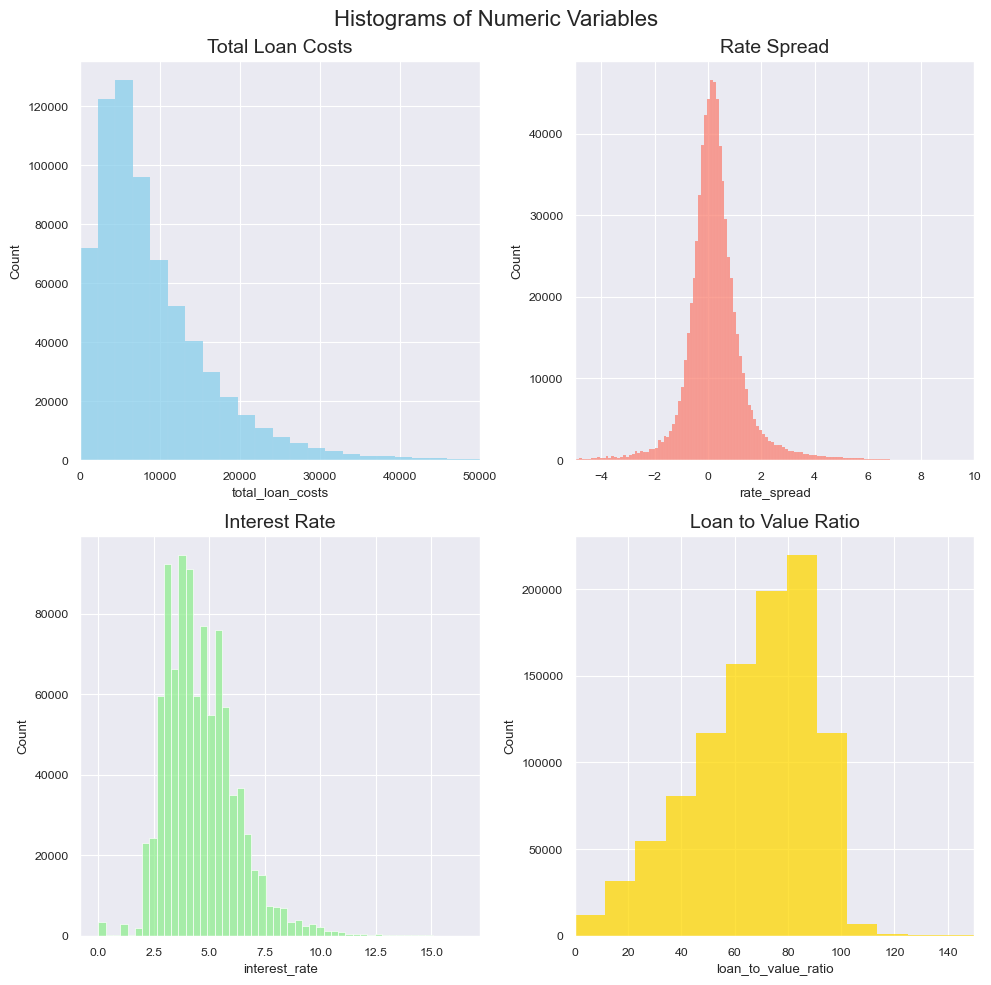

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Histograms of Numeric Variables", fontsize=16)

sns.histplot(total_loan_costs_numeric, bins=1000, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title("Total Loan Costs", fontsize=14)
axs[0, 0].set_xlim(0, 50000)

sns.histplot(rate_spread_numeric, bins=1000, ax=axs[0, 1], color='salmon')
axs[0, 1].set_title("Rate Spread", fontsize=14)
axs[0, 1].set_xlim(-5, 10)

sns.histplot(interest_rate_numeric, bins=50, ax=axs[1, 0], color='lightgreen')
axs[1, 0].set_title("Interest Rate", fontsize=14)

sns.histplot(loan_to_value_ratio_numeric, bins=10000, ax=axs[1, 1], color='gold')
axs[1, 1].set_title("Loan to Value Ratio", fontsize=14)
axs[1, 1].set_xlim(0, 150)

plt.tight_layout()
plt.show()

The inspection of the distribution shows that while the distribution of the **interest_rate** and **rate_spread** is somewhat close to a normal distribution around the mean, the other variables seem to be skewed.

### Casting of appropriate data types

For the later analysis, all columns must be cast to their appropriate data types. Especially the columns that have been cast as objects, but should be numerical values, are of interest here. The following list shows which columns contain values that could not be cast to floats:

In [40]:
for col in HMDA_clean:
    for item in HMDA_clean[col].unique():
        try: 
            float(item)
        except:
            print(col, item)

conforming_loan_limit C
conforming_loan_limit NC
conforming_loan_limit U
loan_to_value_ratio Exempt
interest_rate Exempt
rate_spread Exempt
total_loan_costs Exempt
loan_term Exempt
property_value Exempt
applicant_age 45-54
applicant_age 55-64
applicant_age 25-34
applicant_age 35-44
applicant_age 65-74
applicant_age >74
applicant_age <25
applicant_age_above_62 No
applicant_age_above_62 Yes


It shows that there are two different issues present:
- **conforming_loan_limit** and **applicant_age**: These columns contain categorical variables that are encoded as strings. They are therefore cast to categorical variables. **applicant_age_above_62** will be dropped due to limited added value and potential collinearity with **applicant_age**.
- Then there are the columns where "Exempt" is present. There are several options available on how to deal with these values which hinder a casting to floats. The easiest one would be to just drop the rows containing these values. This might be a valid option as they only account for a very limited amount of rows (see above). However, this would lead to a loss of information and exemptness does most likely not occur at random. Another option would be to used advanced imputation algorithms to replace the "Exempt" values with likely fitting values. This is not optimal practice, as "Exempt" is a value in itself and should be regarded as such in the optimal case, but due to the need to assign some numerical value to these items, it might be feasible to impute likely values for these items based on other characteristics. Other alternatives include imputation methods based on other characteristics or to replace the "Exempt" values with the median, mode, or mean of the respective column. Creating dummy variables or categorizing the whole column is not feasible, as the vast majority of the values are numerical. 

First step: Drop the column **applicant_age_above_62**:

In [41]:
print(HMDA_clean.shape)
HMDA_clean = HMDA_clean.drop(columns = ["applicant_age_above_62"])
print(HMDA_clean.shape)

(1503530, 42)
(1503530, 41)


Second step: Create dummy variables for the categorical columns:

In [42]:
HMDA_clean["conforming_loan_limit"] = HMDA_clean["conforming_loan_limit"].replace({"C": 0, "NC": 1, "U": 2})
# HMDA_clean["conforming_loan_limit"] = HMDA_clean["conforming_loan_limit"].astype("category")
HMDA_clean["conforming_loan_limit"] = HMDA_clean["conforming_loan_limit"].astype("float")

In [43]:
HMDA_clean["applicant_age"] = HMDA_clean["applicant_age"].replace({"<25": 0, "25-34": 1, "35-44": 2, "45-54": 3, "55-64": 4, "65-74": 5, ">74": 6})
# HMDA_clean["applicant_age"] = HMDA_clean["applicant_age"].astype("category")
HMDA_clean["applicant_age"] = HMDA_clean["applicant_age"].astype("float")

Third step: Imputation of the "Exempt" values. For this purpose, a knn imputer will be used (more information here: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html). As discussed above, imputing values for the "Exempt" values is not optimal practice, as "Exempt" is a value in itself and should be regarded as such in the optimal case, but due to the need to assign some numerical value to these items, it might be feasible to impute likely values for these items based on other characteristics:

In [44]:
exempt_df = HMDA_clean[HMDA_clean.isin(["Exempt"]).any(axis=1)]
exempt_indices = exempt_df.index
exempt_df.replace("Exempt", np.nan, inplace=True)
# exempt_df.info

C:\Users\Hauke\AppData\Local\Temp\ipykernel_39884\1866805829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exempt_df.replace("Exempt", np.nan, inplace=True)


In [45]:
imputer = KNNImputer()
imputed_values = imputer.fit_transform(exempt_df)
imputed_df = pd.DataFrame(imputed_values, columns=exempt_df.columns, index=exempt_indices)
HMDA_clean.loc[imputed_df.index, imputed_df.columns] = imputed_df
# imputed_df.info

Now for a check how the imputed distribution compares to the total distribution to assess success of the imputation:

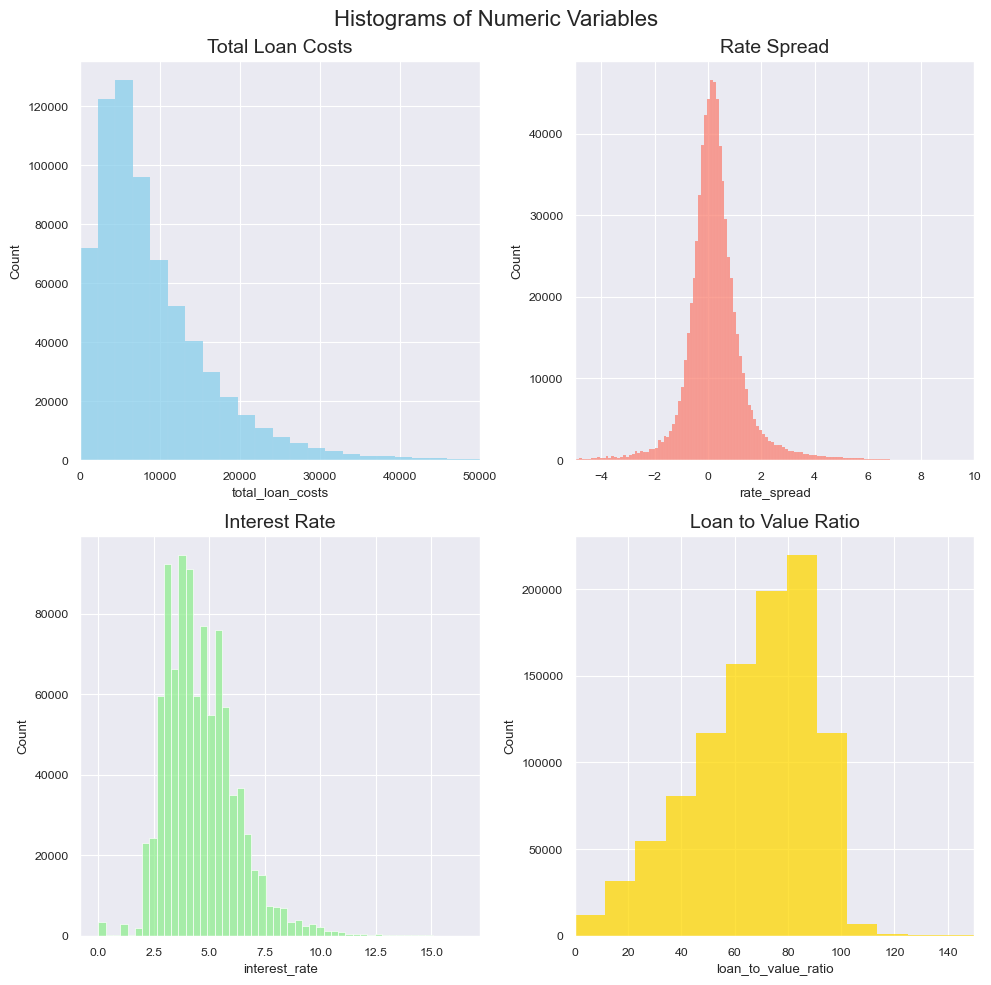

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Histograms of Numeric Variables", fontsize=16)

sns.histplot(total_loan_costs_numeric, bins=1000, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title("Total Loan Costs", fontsize=14)
axs[0, 0].set_xlim(0, 50000)

sns.histplot(rate_spread_numeric, bins=1000, ax=axs[0, 1], color='salmon')
axs[0, 1].set_title("Rate Spread", fontsize=14)
axs[0, 1].set_xlim(-5, 10)

sns.histplot(interest_rate_numeric, bins=50, ax=axs[1, 0], color='lightgreen')
axs[1, 0].set_title("Interest Rate", fontsize=14)

sns.histplot(loan_to_value_ratio_numeric, bins=10000, ax=axs[1, 1], color='gold')
axs[1, 1].set_title("Loan to Value Ratio", fontsize=14)
axs[1, 1].set_xlim(0, 150)

plt.tight_layout()
plt.show()

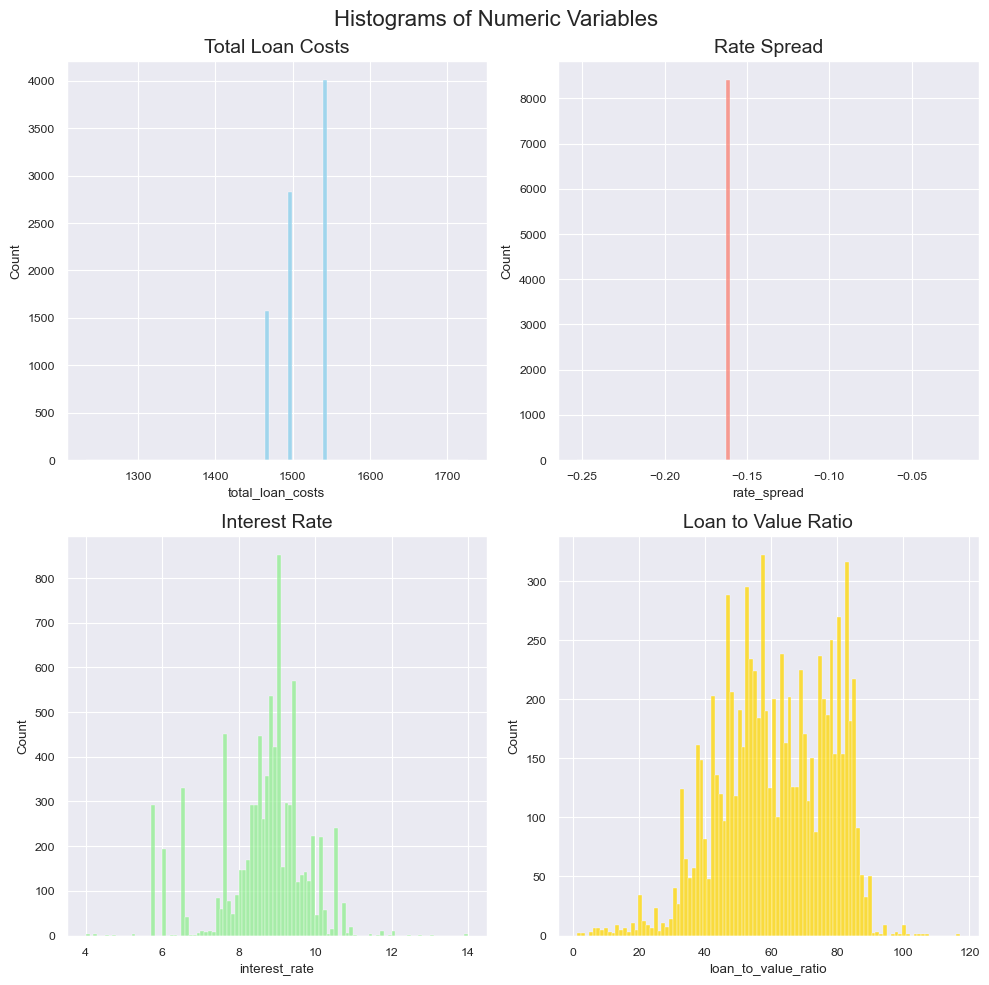

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Histograms of Numeric Variables", fontsize=16)

sns.histplot(imputed_df["total_loan_costs"], bins=100, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title("Total Loan Costs", fontsize=14)

sns.histplot(imputed_df["rate_spread"], bins=100, ax=axs[0, 1], color='salmon')
axs[0, 1].set_title("Rate Spread", fontsize=14)

sns.histplot(imputed_df["interest_rate"], bins=100, ax=axs[1, 0], color='lightgreen')
axs[1, 0].set_title("Interest Rate", fontsize=14)

sns.histplot(imputed_df["loan_to_value_ratio"], bins=100, ax=axs[1, 1], color='gold')
axs[1, 1].set_title("Loan to Value Ratio", fontsize=14)

plt.tight_layout()
plt.show()

While the mean values for **interest_rate** and **rate_spread** vary compared to the underlying data, the distributions of the imputed data are very similar to the original distributions. This might be due to specifics of the imputed loan applications and is a good sign that the imputation has been successful.

In [48]:
for col in HMDA_clean:
    for item in HMDA_clean[col].unique():
        try: 
            float(item)
        except:
            print(col, item)

In [49]:
HMDA_clean.astype(str).apply(lambda x: x.str.contains("Exempt").sum()).sort_values(ascending=False)

county_code                                 0
other_nonamortizing_features                0
occupancy_type                              0
manufactured_home_secured_property_type     0
manufactured_home_land_property_interest    0
total_units                                 0
income                                      0
applicant_credit_score_type                 0
applicant_ethnicity-1                       0
applicant_ethnicity-2                       0
applicant_ethnicity_observed                0
applicant_race-1                            0
applicant_race-2                            0
applicant_race_observed                     0
applicant_sex                               0
applicant_sex_observed                      0
applicant_age                               0
submission_of_application                   0
initially_payable_to_institution            0
property_value                              0
balloon_payment                             0
conforming_loan_limit             

No more non-numerical values are present, which is what was supposed to be achieved.

In [50]:
HMDA_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1503530 entries, 0 to 1503536
Data columns (total 41 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   county_code                               1494293 non-null  float64
 1   conforming_loan_limit                     1503530 non-null  float64
 2   action_taken                              1503530 non-null  int64  
 3   purchaser_type                            1503530 non-null  int64  
 4   preapproval                               1503530 non-null  int64  
 5   loan_type                                 1503530 non-null  int64  
 6   loan_purpose                              1503530 non-null  int64  
 7   lien_status                               1503530 non-null  int64  
 8   reverse_mortgage                          1503530 non-null  int64  
 9   open-end_line_of_credit                   1503530 non-null  int64  
 10  business_or

### Casting Types

While all columns are now numerical, some of them are still cast as objects. The following list shows which columns are still cast as objects:

In [51]:
obj_type = list(HMDA_clean.select_dtypes(include=['object']).columns)
print(obj_type)
print(HMDA_clean[obj_type].head(15))

['loan_to_value_ratio', 'interest_rate', 'rate_spread', 'total_loan_costs', 'loan_term', 'property_value']
   loan_to_value_ratio interest_rate rate_spread total_loan_costs loan_term  \
0                  NaN          6.99         NaN              NaN       480   
1                  NaN          4.38         NaN              NaN       360   
2                  NaN          3.50         NaN         10574.00       360   
3                43.18          5.25        0.18          4342.00       360   
4                53.73           NaN         NaN              NaN       360   
5                  NaN           NaN         NaN              NaN       240   
6                  NaN           NaN         NaN              NaN       360   
7                75.00          7.50        0.60          6005.00       360   
8                  NaN           NaN         NaN              NaN       360   
9                  NaN           NaN         NaN              NaN       360   
10                 NaN  

These can now be cast to numerical values.

In [52]:
HMDA_clean[obj_type] = HMDA_clean[obj_type].astype(float)

In [53]:
HMDA_clean.dtypes.value_counts()

int64      26
float64    15
Name: count, dtype: int64

Some of the columns need further recasting (e.g. float to int / vice versa or numerical to categorical). At this stage however, the data is prepared for the next steps.

### Handling of Missingness

In [54]:
HMDA_clean.isnull().sum().sort_values(ascending=False)

applicant_ethnicity-2                       1339228
applicant_race-2                            1321661
total_loan_costs                             808921
rate_spread                                  771412
interest_rate                                543076
loan_to_value_ratio                          500501
property_value                               332442
income                                       159384
loan_term                                     36895
county_code                                    9237
applicant_ethnicity-1                           857
applicant_race-1                                391
applicant_race_observed                           0
applicant_sex                                     0
applicant_ethnicity_observed                      0
manufactured_home_secured_property_type           0
applicant_sex_observed                            0
applicant_age                                     0
submission_of_application                         0
initially_pa

Looking at the remaining NA values, four different strategies are applied to handle the missing values:
- **applicant_ethnicity-2** and **applicant_race-2**: As discussed above, these are part of the highly important protected attributes. Even though the amount of missing values is high and imputation is not suitable here for logical reasons, these columns will be kept including their missing values in order to not lose the granularity of the data. In fact, missingness in these columns might be informative in itself, as it implies that the applicant has not reported any second race / ethnicity. Therefore, the NA values are kept as a separate category.
- **total_loan_costs**, **rate_spread**, **interest_rate**, **loan_to_value_ratio**, **property_value**, and **income**: These values need to be imputed in order to tackle the high amount of missing values and the importance for the analysis. To strike a balance between complexity of the imputation and the computing resources required, the iterative imputer from the sklearn library is used (more information here: https://scikit-learn.org/stable/modules/impute.html). Imputations will be conducted column-wise, i.e. only one column at a time is imputed using only other features without missing values.
- **loan_term** and **country_code**: Here, the type of missingness will be analyzed. If there are no indicators for MNAR, the rows in question will be dropped, as imputation does not make any sense and the total amount of values is comparably low.
- **applicant_ethnicity-1** and **applicant_race-1**: The missing values here will be dropped as they are low, imputation does not make sense and the values are too crucial for the analysis to be kept as NA values.

In [55]:
HMDA_clean["applicant_ethnicity-2"] = HMDA_clean["applicant_ethnicity-2"].replace({np.nan: 99})
HMDA_clean["applicant_race-2"] = HMDA_clean["applicant_race-2"].replace({np.nan: 99})

In [56]:
HMDA_imputation_copy_tlc = HMDA_clean.copy()
HMDA_imputation_copy_tlc = HMDA_imputation_copy_tlc.drop(columns=["applicant_ethnicity-2", "applicant_race-2", "loan_term", "county_code", "applicant_ethnicity-1", "applicant_race-1"])
HMDA_imputation_copy_tlc = HMDA_imputation_copy_tlc.drop(columns=["rate_spread", "interest_rate", "loan_to_value_ratio", "property_value", "income"])

imputer = IterativeImputer(max_iter=5, random_state=0) # KNNImputer()

imputed_values_tlc = imputer.fit_transform(HMDA_imputation_copy_tlc)
HMDA_imputed_tlc = pd.DataFrame(imputed_values_tlc, columns=HMDA_imputation_copy_tlc.columns)

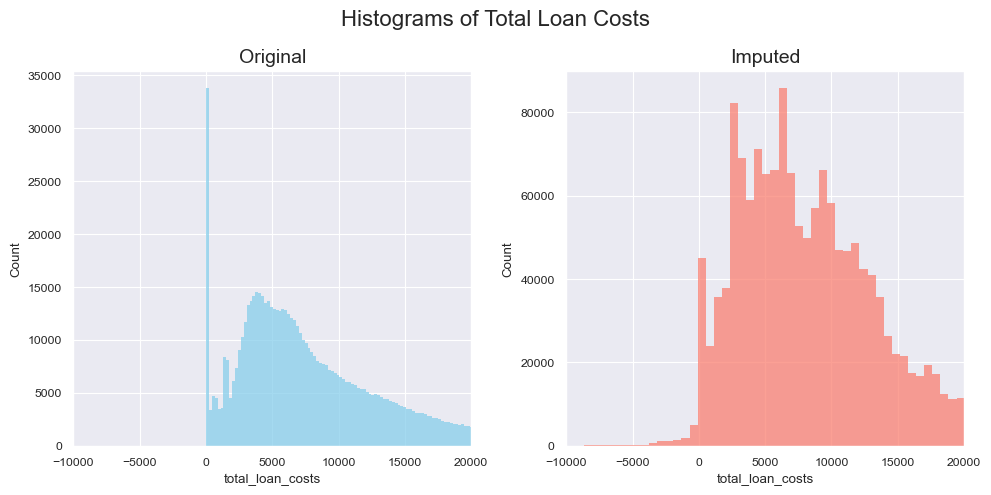

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Histograms of Total Loan Costs", fontsize=16)

sns.histplot(HMDA_clean["total_loan_costs"], bins=10000, ax=axs[0], color='skyblue')
axs[0].set_title("Original", fontsize=14)
axs[0].set_xlim(-10000, 20000)

sns.histplot(HMDA_imputed_tlc["total_loan_costs"], bins=10000, ax=axs[1], color='salmon')
axs[1].set_title("Imputed", fontsize=14)
axs[1].set_xlim(-10000, 20000)

plt.tight_layout()
plt.show()

In [58]:
HMDA_clean["total_loan_costs"] = HMDA_imputed_tlc["total_loan_costs"]

HMDA_imputation_copy_rs = HMDA_clean.copy()
HMDA_imputation_copy_rs = HMDA_imputation_copy_rs.drop(columns=["applicant_ethnicity-2", "applicant_race-2", "loan_term", "county_code", "applicant_ethnicity-1", "applicant_race-1"])
HMDA_imputation_copy_rs = HMDA_imputation_copy_rs.drop(columns=["total_loan_costs", "interest_rate", "loan_to_value_ratio", "property_value", "income"])

imputer = IterativeImputer(max_iter=5, random_state=0) # KNNImputer()

imputed_values_rs = imputer.fit_transform(HMDA_imputation_copy_rs)
HMDA_imputed_rs = pd.DataFrame(imputed_values_rs, columns=HMDA_imputation_copy_rs.columns)

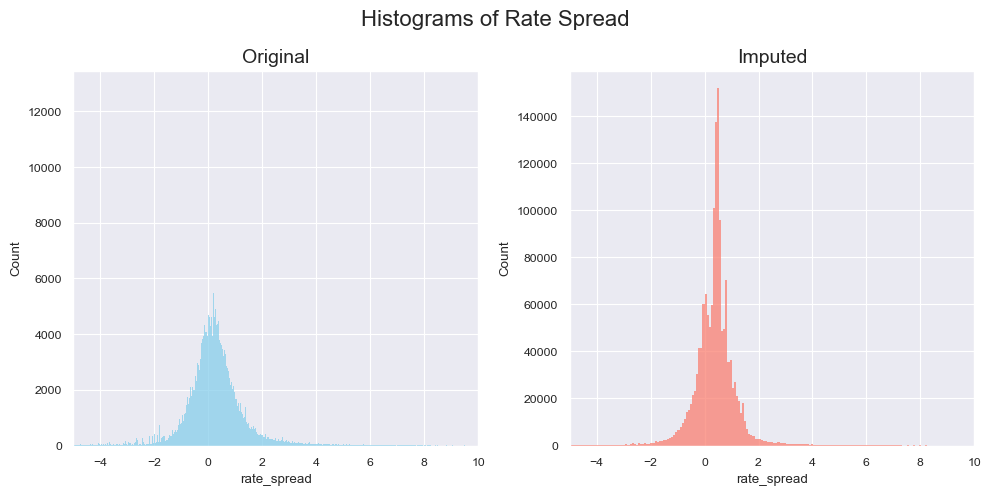

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Histograms of Rate Spread", fontsize=16)

sns.histplot(HMDA_clean["rate_spread"], bins=10000, ax=axs[0], color='skyblue')
axs[0].set_title("Original", fontsize=14)
axs[0].set_xlim(-5, 10)

sns.histplot(HMDA_imputed_rs["rate_spread"], bins=10000, ax=axs[1], color='salmon')
axs[1].set_title("Imputed", fontsize=14)
axs[1].set_xlim(-5, 10)

plt.tight_layout()
plt.show()

In [60]:
HMDA_clean["rate_spread"] = HMDA_imputed_rs["rate_spread"]

HMDA_imputation_copy_ir = HMDA_clean.copy()
HMDA_imputation_copy_ir = HMDA_imputation_copy_ir.drop(columns=["applicant_ethnicity-2", "applicant_race-2", "loan_term", "county_code", "applicant_ethnicity-1", "applicant_race-1"])
HMDA_imputation_copy_ir = HMDA_imputation_copy_ir.drop(columns=["total_loan_costs", "rate_spread", "loan_to_value_ratio", "property_value", "income"])

imputer = IterativeImputer(max_iter=5, random_state=0) # KNNImputer()

imputed_values_ir = imputer.fit_transform(HMDA_imputation_copy_ir)
HMDA_imputed_ir = pd.DataFrame(imputed_values_ir, columns=HMDA_imputation_copy_ir.columns)

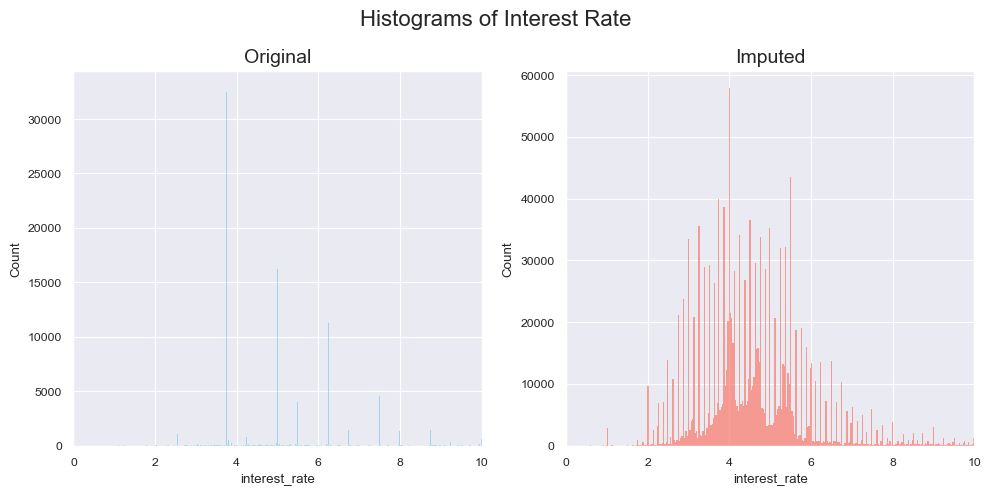

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Histograms of Interest Rate", fontsize=16)

sns.histplot(HMDA_clean["interest_rate"], bins=10000, ax=axs[0], color='skyblue')
axs[0].set_title("Original", fontsize=14)
axs[0].set_xlim(0, 10)

sns.histplot(HMDA_imputed_ir["interest_rate"], bins=10000, ax=axs[1], color='salmon')
axs[1].set_title("Imputed", fontsize=14)
axs[1].set_xlim(0, 10)

plt.tight_layout()
plt.show()

In [62]:
HMDA_clean["interest_rate"] = HMDA_imputed_ir["interest_rate"]

HMDA_imputation_copy_ltv = HMDA_clean.copy()
HMDA_imputation_copy_ltv = HMDA_imputation_copy_ltv.drop(columns=["applicant_ethnicity-2", "applicant_race-2", "loan_term", "county_code", "applicant_ethnicity-1", "applicant_race-1"])
HMDA_imputation_copy_ltv = HMDA_imputation_copy_ltv.drop(columns=["total_loan_costs", "rate_spread", "interest_rate", "property_value", "income"])

imputer = IterativeImputer(max_iter=5, random_state=0) # KNNImputer()

imputed_values_ltv = imputer.fit_transform(HMDA_imputation_copy_ltv)
HMDA_imputed_ltv = pd.DataFrame(imputed_values_ltv, columns=HMDA_imputation_copy_ltv.columns)

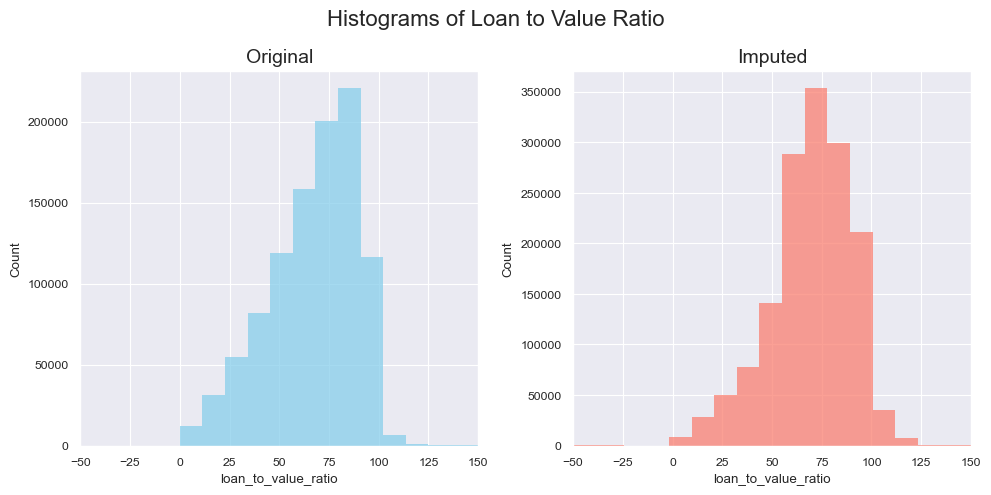

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Histograms of Loan to Value Ratio", fontsize=16)

sns.histplot(HMDA_clean["loan_to_value_ratio"], bins=10000, ax=axs[0], color='skyblue')
axs[0].set_title("Original", fontsize=14)
axs[0].set_xlim(-50, 150)

sns.histplot(HMDA_imputed_ltv["loan_to_value_ratio"], bins=10000, ax=axs[1], color='salmon')
axs[1].set_title("Imputed", fontsize=14)
axs[1].set_xlim(-50, 150)

plt.tight_layout()
plt.show()

In [64]:
HMDA_clean["loan_to_value_ratio"] = HMDA_imputed_ltv["loan_to_value_ratio"]

HMDA_imputation_copy_pv = HMDA_clean.copy()
HMDA_imputation_copy_pv = HMDA_imputation_copy_pv.drop(columns=["applicant_ethnicity-2", "applicant_race-2", "loan_term", "county_code", "applicant_ethnicity-1", "applicant_race-1"])
HMDA_imputation_copy_pv = HMDA_imputation_copy_pv.drop(columns=["total_loan_costs", "rate_spread", "interest_rate", "loan_to_value_ratio", "income"])

imputer = IterativeImputer(max_iter=5, random_state=0) # KNNImputer()

imputed_values_pv = imputer.fit_transform(HMDA_imputation_copy_pv)
HMDA_imputed_pv = pd.DataFrame(imputed_values_pv, columns=HMDA_imputation_copy_pv.columns)

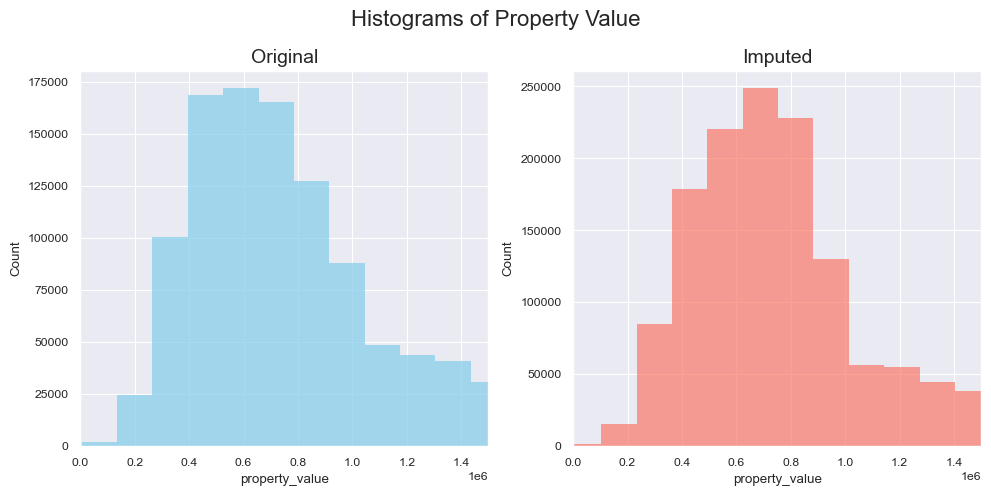

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Histograms of Property Value", fontsize=16)

sns.histplot(HMDA_clean["property_value"], bins=10000, ax=axs[0], color='skyblue')
axs[0].set_title("Original", fontsize=14)
axs[0].set_xlim(0, 1500000)

sns.histplot(HMDA_imputed_pv["property_value"], bins=10000, ax=axs[1], color='salmon')
axs[1].set_title("Imputed", fontsize=14)
axs[1].set_xlim(0, 1500000)

plt.tight_layout()
plt.show()

In [66]:
HMDA_clean["property_value"] = HMDA_imputed_pv["property_value"]

HMDA_imputation_copy_inc = HMDA_clean.copy()
HMDA_imputation_copy_inc = HMDA_imputation_copy_inc.drop(columns=["applicant_ethnicity-2", "applicant_race-2", "loan_term", "county_code", "applicant_ethnicity-1", "applicant_race-1"])
HMDA_imputation_copy_inc = HMDA_imputation_copy_inc.drop(columns=["total_loan_costs", "rate_spread", "interest_rate", "loan_to_value_ratio", "property_value"])

imputer = IterativeImputer(max_iter=5, random_state=0) # KNNImputer()

imputed_values_inc = imputer.fit_transform(HMDA_imputation_copy_inc)
HMDA_imputed_inc = pd.DataFrame(imputed_values_inc, columns=HMDA_imputation_copy_inc.columns)

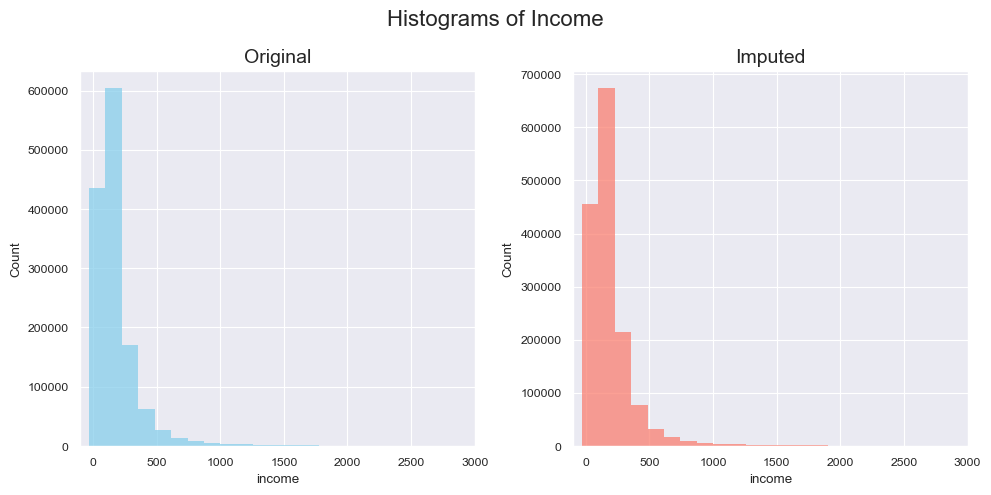

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Histograms of Income", fontsize=16)

sns.histplot(HMDA_clean["income"], bins=100000, ax=axs[0], color='skyblue')
axs[0].set_title("Original", fontsize=14)
axs[0].set_xlim(-100, 3000)

sns.histplot(HMDA_imputed_inc["income"], bins=100000, ax=axs[1], color='salmon')
axs[1].set_title("Imputed", fontsize=14)
axs[1].set_xlim(-100, 3000)

plt.tight_layout()
plt.show()

In [68]:
print(HMDA_raw["income"].describe(), "\n",
        HMDA_clean["income"].describe(), "\n",
        HMDA_imputed_inc["income"].describe())

count    1341088.00
mean         227.71
std        14566.75
min      -899459.00
25%           84.00
50%          132.00
75%          213.00
max     12002960.00
Name: income, dtype: float64 
 count    1344146.00
mean         227.90
std        14550.18
min      -899459.00
25%           84.00
50%          132.00
75%          213.00
max     12002960.00
Name: income, dtype: float64 
 count    1503530.00
mean         233.24
std        13764.49
min      -899459.00
25%           87.00
50%          139.00
75%          225.21
max     12002960.00
Name: income, dtype: float64


In [69]:
HMDA_clean["income"] = HMDA_imputed_inc["income"]

The iterative imputer seems to tend to impute values close to the median and/or mean. This is not the optimal procedure, but definitely feasible for the purpose of this analysis. Next up is dropping the NA values where feasible as discussed above:

In [70]:
print(HMDA_clean.shape)                                
HMDA_clean = HMDA_clean.dropna(subset=["income", "total_loan_costs", "rate_spread", "interest_rate", "loan_to_value_ratio", "property_value"])
print(HMDA_clean.shape)

(1503530, 41)
(1503523, 41)


In [71]:
print(HMDA_clean.shape)
HMDA_clean = HMDA_clean.dropna(subset=["applicant_ethnicity-1", "applicant_race-1"])
print(HMDA_clean.shape)

(1503523, 41)
(1502306, 41)


In [72]:
print(HMDA_clean[HMDA_clean["loan_term"].isnull()]["loan_amount"].describe(), "\n",
      HMDA_clean[HMDA_clean["loan_term"].notnull()]["loan_amount"].describe(), "\n",
      HMDA_clean[HMDA_clean["county_code"].isnull()]["loan_amount"].describe(), "\n",
        HMDA_clean[HMDA_clean["county_code"].notnull()]["loan_amount"].describe())

count       36891.00
mean       491599.17
std       5852780.81
min          5000.00
25%        205000.00
50%        355000.00
75%        525000.00
max     743375000.00
Name: loan_amount, dtype: float64 
 count      1465415.00
mean        503071.14
std        1065009.97
min           5000.00
25%         215000.00
50%         395000.00
75%         615000.00
max     1000005000.00
Name: loan_amount, dtype: float64 
 count       9235.00
mean      723893.34
std       875999.44
min         5000.00
25%       305000.00
50%       515000.00
75%       825000.00
max     24105000.00
Name: loan_amount, dtype: float64 
 count      1493071.00
mean        501421.85
std        1398050.64
min           5000.00
25%         215000.00
50%         395000.00
75%         605000.00
max     1000005000.00
Name: loan_amount, dtype: float64


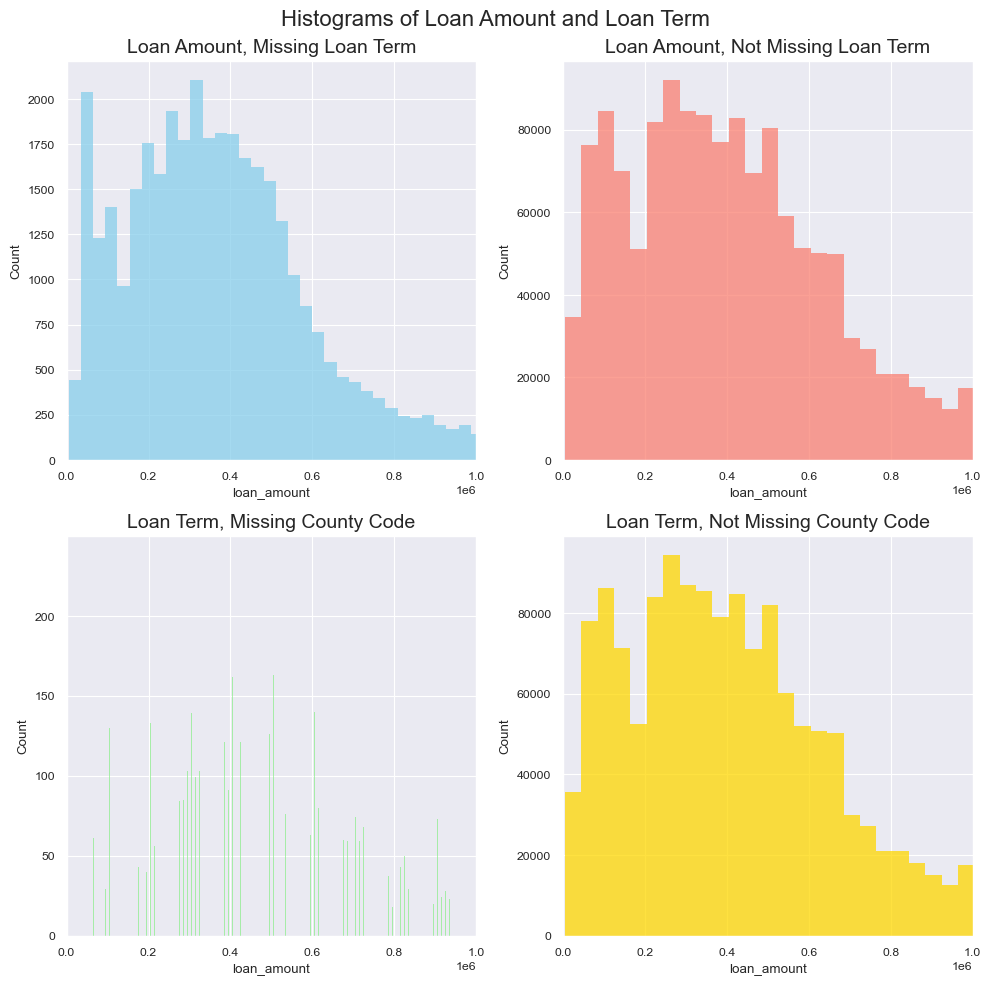

In [73]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Histograms of Loan Amount and Loan Term", fontsize=16)

sns.histplot(HMDA_clean[HMDA_clean["loan_term"].isnull()]["loan_amount"], bins=25000, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title("Loan Amount, Missing Loan Term", fontsize=14)
axs[0, 0].set_xlim(0, 1000000)

sns.histplot(HMDA_clean[~HMDA_clean["loan_term"].isnull()]["loan_amount"], bins=25000, ax=axs[0, 1], color='salmon')
axs[0, 1].set_title("Loan Amount, Not Missing Loan Term", fontsize=14)
axs[0, 1].set_xlim(0, 1000000)

sns.histplot(HMDA_clean[HMDA_clean["county_code"].isnull()]["loan_amount"], bins=25000, ax=axs[1, 0], color='lightgreen')
axs[1, 0].set_title("Loan Term, Missing County Code", fontsize=14)
axs[1, 0].set_xlim(0, 1000000)

sns.histplot(HMDA_clean[~HMDA_clean["county_code"].isnull()]["loan_amount"], bins=25000, ax=axs[1, 1], color='gold')
axs[1, 1].set_title("Loan Term, Not Missing County Code", fontsize=14)
axs[1, 1].set_xlim(0, 1000000)

plt.tight_layout()
plt.show()

In [74]:
print(normaltest(HMDA_clean[HMDA_clean["loan_term"].isnull()]["loan_amount"]))
print(normaltest(HMDA_clean[~HMDA_clean["loan_term"].isnull()]["loan_amount"]))
print(normaltest(HMDA_clean[HMDA_clean["county_code"].isnull()]["loan_amount"]))
print(normaltest(HMDA_clean[~HMDA_clean["county_code"].isnull()]["loan_amount"]))

print(ttest_ind(HMDA_clean[HMDA_clean["loan_term"].isnull()]["loan_amount"], HMDA_clean[~HMDA_clean["loan_term"].isnull()]["loan_amount"], equal_var=False))
print(ttest_ind(HMDA_clean[HMDA_clean["county_code"].isnull()]["loan_amount"], HMDA_clean[~HMDA_clean["county_code"].isnull()]["loan_amount"], equal_var=False))

print(mannwhitneyu(HMDA_clean[HMDA_clean["loan_term"].isnull()]["loan_amount"], HMDA_clean[~HMDA_clean["loan_term"].isnull()]["loan_amount"]))
print(mannwhitneyu(HMDA_clean[HMDA_clean["county_code"].isnull()]["loan_amount"], HMDA_clean[~HMDA_clean["county_code"].isnull()]["loan_amount"]))

NormaltestResult(statistic=151030.0444140247, pvalue=0.0)
NormaltestResult(statistic=9560097.481618444, pvalue=0.0)
NormaltestResult(statistic=11412.861362731373, pvalue=0.0)
NormaltestResult(statistic=9128078.836049499, pvalue=0.0)
Ttest_indResult(statistic=-0.3763180189984693, pvalue=0.7066826455585062)
Ttest_indResult(statistic=24.215569358786578, pvalue=9.145429898273471e-126)
MannwhitneyuResult(statistic=24790573036.5, pvalue=3.036561788234526e-163)
MannwhitneyuResult(statistic=8328081810.0, pvalue=4.948712123226288e-261)


Numerical and visual inspection of the distributions of the loan_amount for loan_term and country_code for missing vs. non-missing values does not provide a clear picture. Upon visual inspection, the distributions seem comparable. The summary statistics are comparable, although impacted by outliers. A t-test indicates a difference in the loan_amount for the county_code variable. As the distributions do not fulfill normality criteria , the Mann-Whitney U test was conducted, which indicates a difference in the distributions of the loan_amount for the country_code variable. This indicates that the missingness might not be at random. As handling the missing values in a meaningful way is not possible and the amount of rows dropped is comparably low, the rows in question are dropped, even though this is not optimal practice.

In [75]:
print(HMDA_clean.shape)
HMDA_clean = HMDA_clean.dropna(subset = ["loan_term", "county_code"])
print(HMDA_clean.shape)

(1502306, 41)
(1456973, 41)


In [76]:
HMDA_clean.isnull().sum().sort_values(ascending=False)

county_code                                 0
other_nonamortizing_features                0
occupancy_type                              0
manufactured_home_secured_property_type     0
manufactured_home_land_property_interest    0
total_units                                 0
income                                      0
applicant_credit_score_type                 0
applicant_ethnicity-1                       0
applicant_ethnicity-2                       0
applicant_ethnicity_observed                0
applicant_race-1                            0
applicant_race-2                            0
applicant_race_observed                     0
applicant_sex                               0
applicant_sex_observed                      0
applicant_age                               0
submission_of_application                   0
initially_payable_to_institution            0
property_value                              0
balloon_payment                             0
conforming_loan_limit             

### Handling of Outliers

While the most grave outliers affecting the distributions have already been removed from the relevant columns in the previous steps, no thorough analysis of the remaining outliers has been conducted yet.

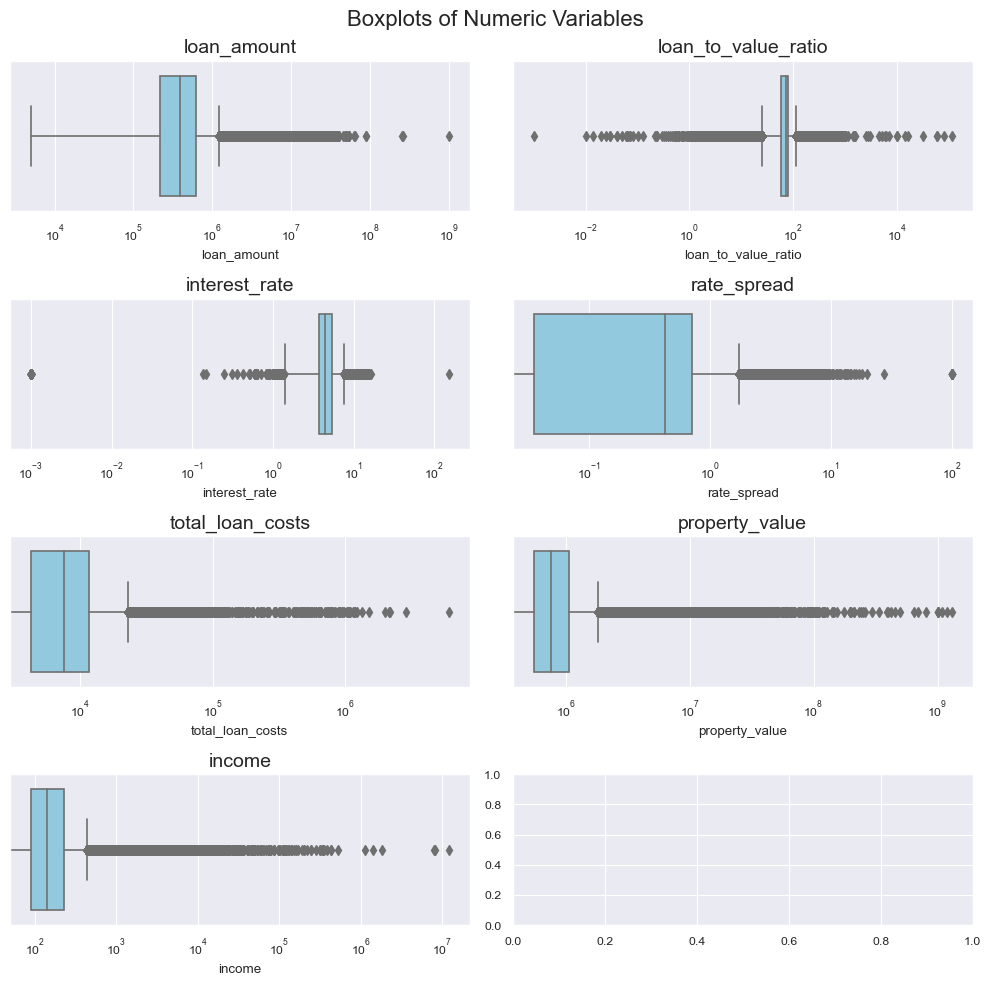

In [77]:
outlier_analysis_columns = ["loan_amount", "loan_to_value_ratio", "interest_rate", "rate_spread", "total_loan_costs", "property_value", "income"]

fig, axs = plt.subplots(4, 2, figsize=(10, 10))
fig.suptitle("Boxplots of Numeric Variables", fontsize=16)

for i, col in enumerate(outlier_analysis_columns):
    sns.boxplot(x=HMDA_clean[col], ax=axs[i//2, i%2], color='skyblue')
    axs[i//2, i%2].set_title(col, fontsize=14)
    axs[i//2, i%2].set_xscale('log')

plt.tight_layout()
plt.show()

In [78]:
for item in outlier_analysis_columns:
    print(item)
    print(HMDA_clean[item].nlargest(5))
    print(HMDA_clean[item].nsmallest(5))
    print()

loan_amount
1275141   1000005000.00
488590     265005000.00
197681     252005000.00
439171      90005000.00
459383      88205000.00
Name: loan_amount, dtype: float64
29903   5000.00
34299   5000.00
35666   5000.00
35669   5000.00
56113   5000.00
Name: loan_amount, dtype: float64

loan_to_value_ratio
1415190   113636.36
627194     82608.70
64374      60000.00
1415136    59688.09
258956     31460.70
Name: loan_to_value_ratio, dtype: float64
317518   0.00
472573   0.01
658594   0.01
489013   0.02
886995   0.03
Name: loan_to_value_ratio, dtype: float64

interest_rate
960309    150.93
223600     16.38
203379     16.00
1204481    15.15
223668     15.13
Name: interest_rate, dtype: float64
1275135   -169.65
559263    -124.88
559643    -115.37
558861     -60.47
558817     -48.43
Name: interest_rate, dtype: float64

rate_spread
227349   100.00
989636   100.00
989690   100.00
990060   100.00
990932   100.00
Name: rate_spread, dtype: float64
960309    -670.74
1275135    -97.97
559263     -72.92
55

Both visual and numerical inspection prove a high amount of outliers in the numerical values. Upon closer inspection of the numerical values, some of the outliers seem to be irrational and are therefore removed. This initial approach of outlier removal is very conservative and might be adjusted in the future. Just deleting the rows containing outliers is not optimal practice, but due to the sheer size of the dataset, this is the most feasible approach in this case. In this step, only the very highest and/or lowest outliers are removed, mainly based on logical reasoning. The deletions proposed here only amount to a very small amount of the total dataset.

In this step, the following values are removed:
- **loan_amount**, **loan_to_value_ratio**, **total_loan_costs**, **loan_term**, **property_value**, and **income**: The highest 0.1% of the values are removed. While the flat assumption of 0.1% might seem arbitrary, this procedure aligns well with logical reasoning, as e.g. applicants earning above one billion USD per year seem somewhat unlikely. The same applies to the other variables. As there are multiple negative outliers present in the **income** and **loan_to_value_ratio** columns, the lowest 0.1% of the values are removed as well.
- **rate_spread**: There is one irrational negative value that is being removed, as well as all values showing a rate_spread of 100

In [79]:
print(HMDA_clean.shape)

HMDA_clean = HMDA_clean[HMDA_clean["loan_amount"] < HMDA_clean["loan_amount"].quantile(0.999)]
print(HMDA_clean.shape)
HMDA_clean = HMDA_clean[HMDA_clean["total_loan_costs"] < HMDA_clean["total_loan_costs"].quantile(0.999)]
print(HMDA_clean.shape)
HMDA_clean = HMDA_clean[HMDA_clean["loan_term"] < HMDA_clean["loan_term"].quantile(0.999)]
print(HMDA_clean.shape)
HMDA_clean = HMDA_clean[HMDA_clean["property_value"] < HMDA_clean["property_value"].quantile(0.999)]
print(HMDA_clean.shape)
HMDA_clean = HMDA_clean[HMDA_clean["income"] < HMDA_clean["income"].quantile(0.999)]
print(HMDA_clean.shape)
HMDA_clean = HMDA_clean[HMDA_clean["income"] > HMDA_clean["income"].quantile(0.001)]
print(HMDA_clean.shape)
HMDA_clean = HMDA_clean[HMDA_clean["loan_to_value_ratio"] < HMDA_clean["loan_to_value_ratio"].quantile(0.999)]
print(HMDA_clean.shape)
HMDA_clean = HMDA_clean[HMDA_clean["loan_to_value_ratio"] > HMDA_clean["loan_to_value_ratio"].quantile(0.001)]
print(HMDA_clean.shape)

HMDA_clean = HMDA_clean[HMDA_clean["income"] > HMDA_clean["income"].quantile(0.001)]
print(HMDA_clean.shape)

HMDA_clean = HMDA_clean[HMDA_clean["rate_spread"] < 100]
print(HMDA_clean.shape)

(1456973, 41)
(1455515, 41)
(1454059, 41)
(1433988, 41)
(1432553, 41)
(1431120, 41)
(1417839, 41)
(1416420, 41)
(1415003, 41)
(1413439, 41)
(1413430, 41)


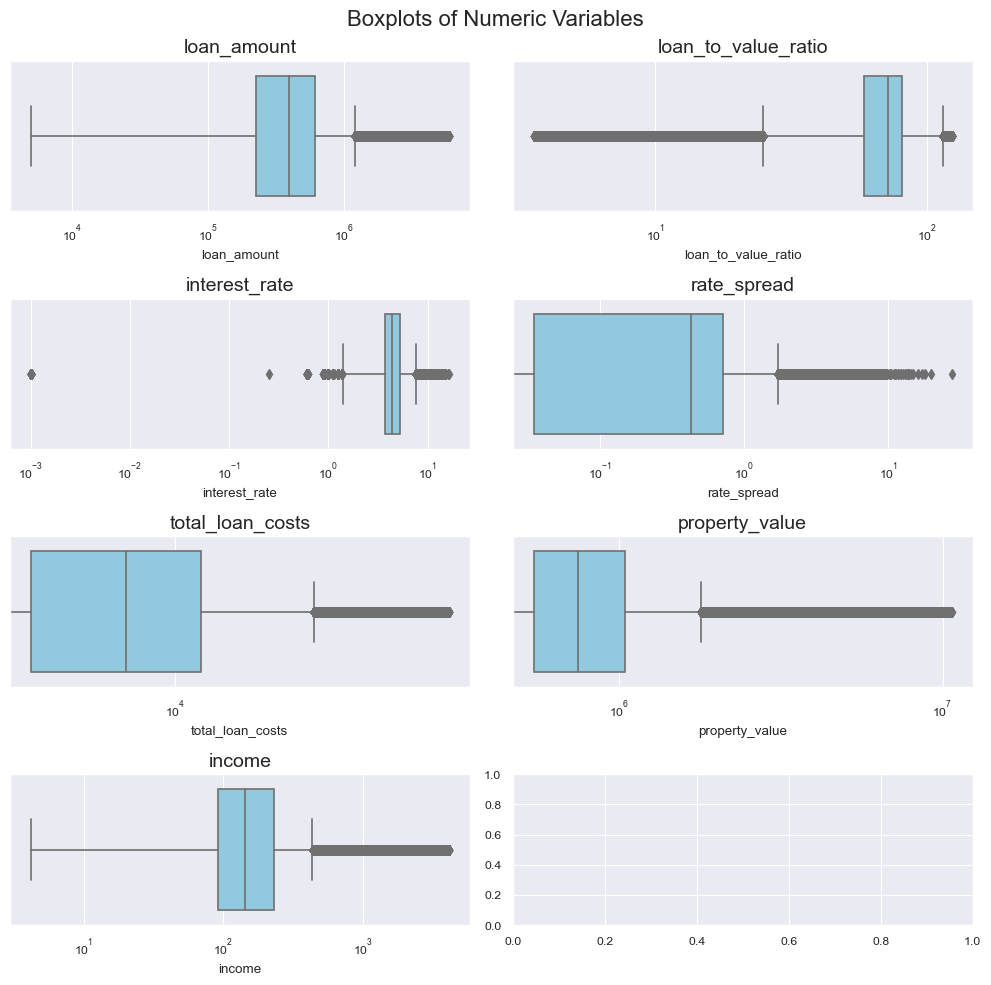

In [80]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
fig.suptitle("Boxplots of Numeric Variables", fontsize=16)

for i, col in enumerate(outlier_analysis_columns):
    sns.boxplot(x=HMDA_clean[col], ax=axs[i//2, i%2], color='skyblue')
    axs[i//2, i%2].set_title(col, fontsize=14)
    axs[i//2, i%2].set_xscale('log')

plt.tight_layout()
plt.show()

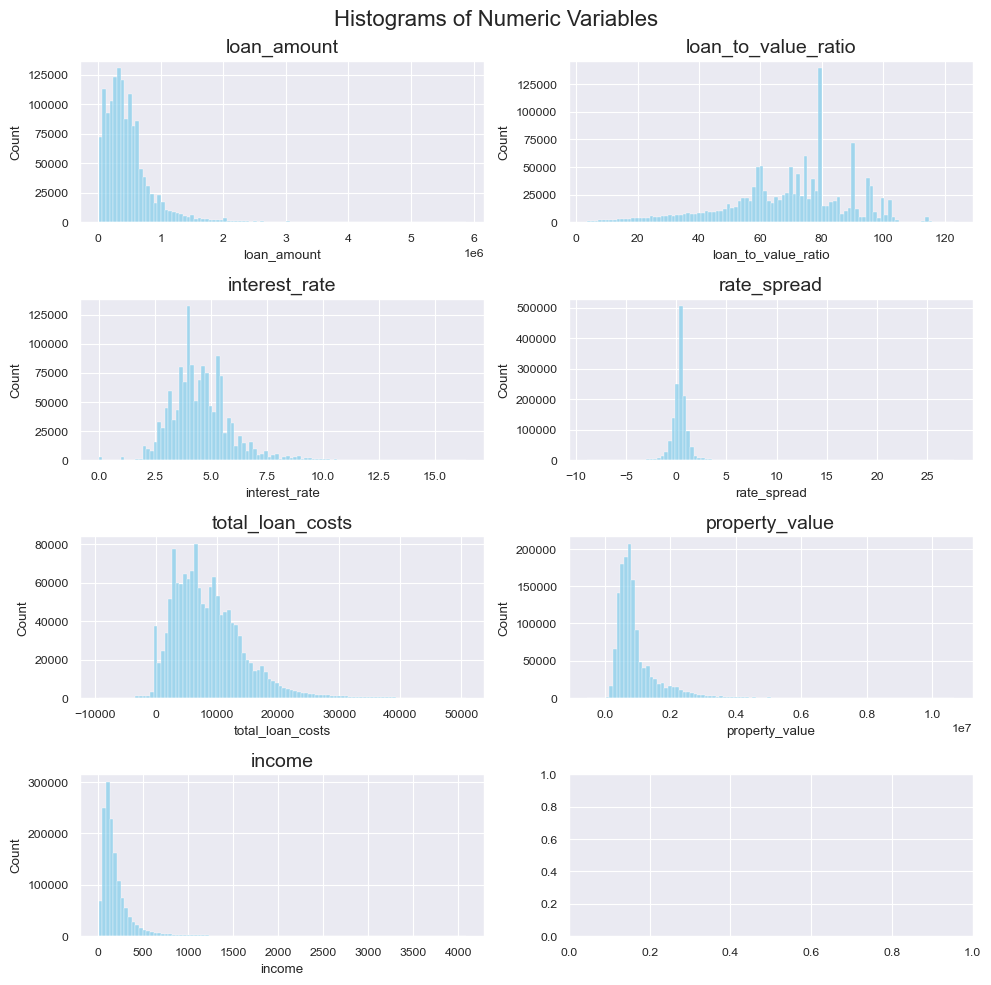

In [81]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
fig.suptitle("Histograms of Numeric Variables", fontsize=16)

for i, col in enumerate(outlier_analysis_columns):
    sns.histplot(HMDA_clean[col], bins=100, ax=axs[i//2, i%2], color='skyblue')
    axs[i//2, i%2].set_title(col, fontsize=14)

plt.tight_layout()
plt.show()

It looks like the removal of the outliers has been successful. The distributions of the variables are now more suitable for the upcoming analysis. 

Due to performance issues arising from the length of this notebook, the data is now saved in its current state and will be reloaded in the next notebook for further analysis and data cleaning.

In [82]:
# save a pickle of the cleaned dataset
HMDA_clean.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/processed/HMDA_cleaned.pkl")